# OPIS

Notebook, w którym przeprowadzane sa dalsze eksperymenty majace na celu dalsza optymalizacje sieci z dwukierunkowa warstwa LSTM - poprawienie jakosci modelu

# Importy

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import csv

# to play the audio files
from IPython.display import Audio

import tensorflow as tf
from tensorflow.keras.models import Sequential

from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Wczytanie danych

In [3]:
model_name = "bidirectional_lstm"
optimizer = "adam"
idx = 4

In [4]:
classes = ["Anger", "Happy", "Neutral", "Sad", "Fear", "Disgust"]

In [5]:
Root_dir = '../data/kaggle/input/speech-emotion-recognition-en'

In [6]:
Crema_path = Root_dir + "/Crema/" 
Ravdess_path = Root_dir + "/Ravdess/audio_speech_actors_01-24/"
Savee_path = Root_dir + "/Savee/"
Tess_path = Root_dir + "/Tess/"

In [7]:
Crema_dir_list = os.listdir(Crema_path)
Ravdess_dir_list = os.listdir(Ravdess_path)
Savee_dir_list = os.listdir(Savee_path)
Tess_dir_list = os.listdir(Tess_path)

# Preprocessing danych

## Crema

In [8]:
Ex_Crema_dir_list = Crema_dir_list[:15]
Ex_Crema_dir_list

['1022_ITS_ANG_XX.wav',
 '1037_ITS_ANG_XX.wav',
 '1060_ITS_NEU_XX.wav',
 '1075_ITS_NEU_XX.wav',
 '1073_IOM_DIS_XX.wav',
 '1066_IOM_DIS_XX.wav',
 '1078_IWL_SAD_XX.wav',
 '1029_TAI_FEA_XX.wav',
 '1039_IEO_SAD_MD.wav',
 '1008_TAI_HAP_XX.wav',
 '1018_TSI_FEA_XX.wav',
 '1028_IEO_SAD_HI.wav',
 '1039_TSI_HAP_XX.wav',
 '1064_ITS_HAP_XX.wav',
 '1071_ITS_HAP_XX.wav']

In [9]:
emotions_crema = []
paths_crema = []

for it in Crema_dir_list:
    # storing file paths
    paths_crema.append(Crema_path + it)
    # storing file emotions
    part = it.split('_')
    if part[2] == 'SAD':
        emotions_crema.append('Sad')
    elif part[2] == 'ANG':
        emotions_crema.append('Anger')
    elif part[2] == 'DIS':
        emotions_crema.append('Disgust')
    elif part[2] == 'FEA':
        emotions_crema.append('Fear')
    elif part[2] == 'HAP':
        emotions_crema.append('Happy')
    elif part[2] == 'NEU':
        emotions_crema.append('Neutral')
    else:
        emotions_crema.append('Unknown')
        
# dataframe for emotion of files
emotions_crema_df = pd.DataFrame(emotions_crema, columns=['Emotions'])

# dataframe for path of files.
path_crema_df = pd.DataFrame(paths_crema, columns=['Path'])
Crema_df = pd.concat([emotions_crema_df, path_crema_df], axis=1)
print(Crema_df.shape)
Crema_df.head()

(7442, 2)


Emotions                                               Path
0    Anger  ../data/kaggle/input/speech-emotion-recognitio...
1    Anger  ../data/kaggle/input/speech-emotion-recognitio...
2  Neutral  ../data/kaggle/input/speech-emotion-recognitio...
3  Neutral  ../data/kaggle/input/speech-emotion-recognitio...
4  Disgust  ../data/kaggle/input/speech-emotion-recognitio...

In [10]:
[Crema_df["Emotions"].unique().tolist() for i in Crema_df.columns]

[['Anger', 'Neutral', 'Disgust', 'Sad', 'Fear', 'Happy'],
 ['Anger', 'Neutral', 'Disgust', 'Sad', 'Fear', 'Happy']]

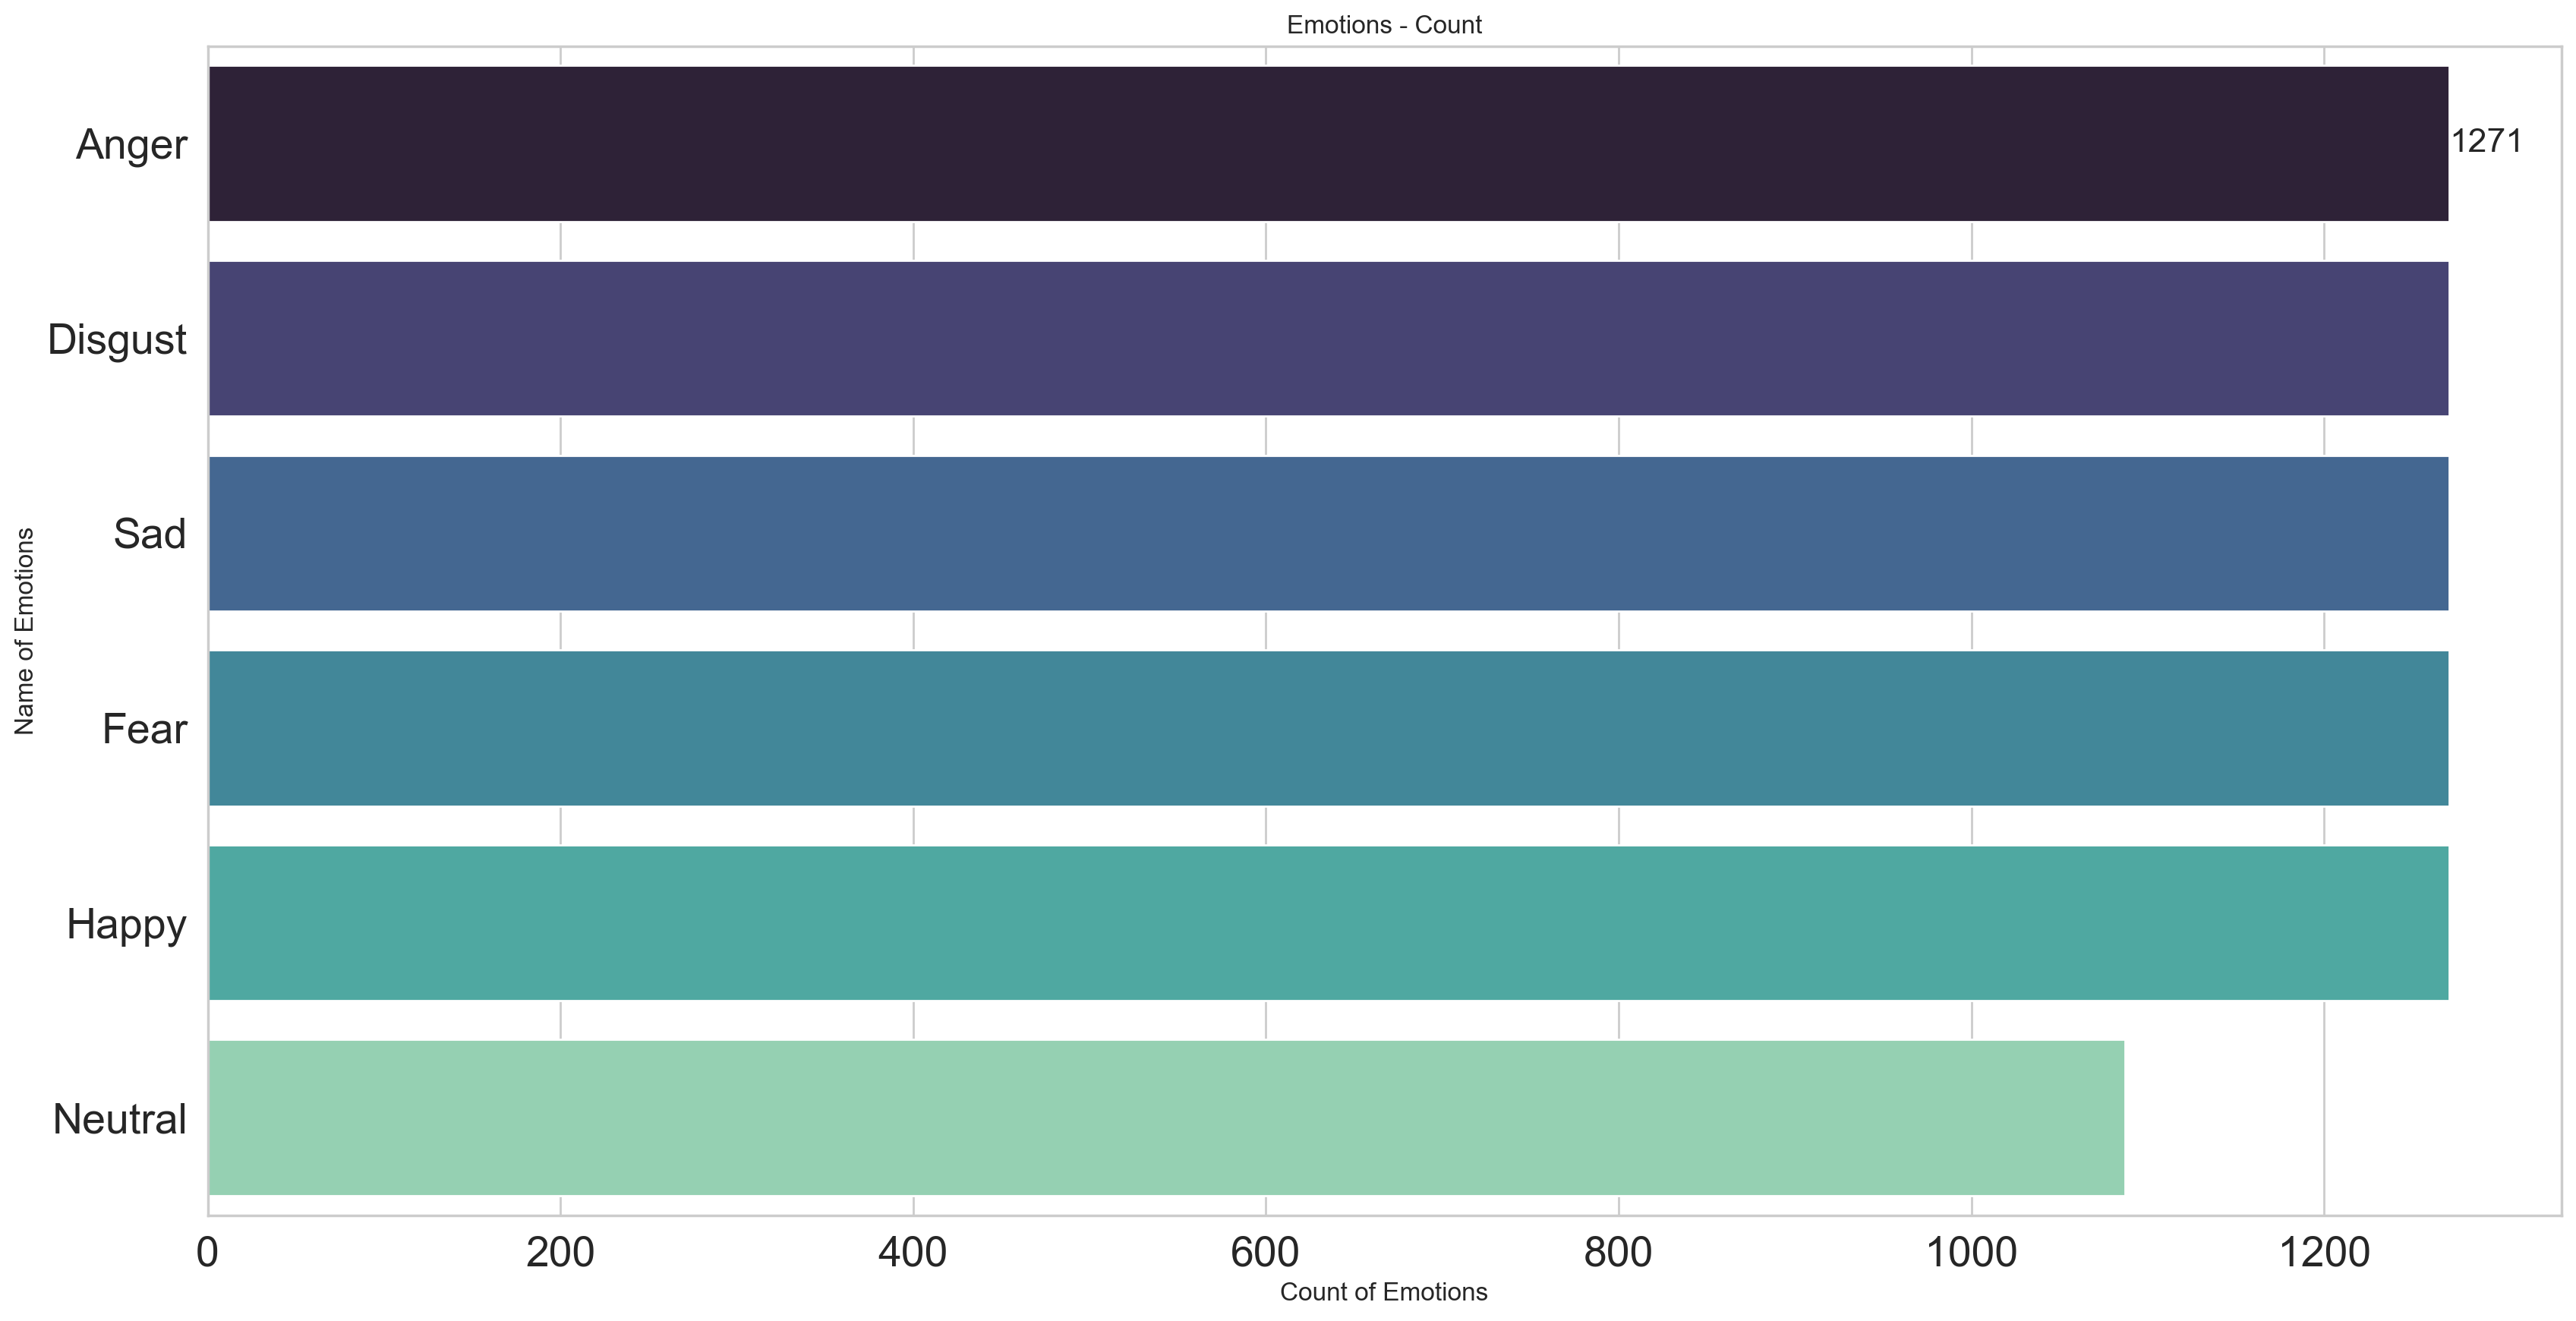

In [11]:
sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(20,10),dpi=200)
Count_emotion = Crema_df['Emotions'].value_counts()[:]
ax = sns.barplot(x= Count_emotion, y= Count_emotion.index, palette="mako")
ax.bar_label(ax.containers[0],fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Name of Emotions")
plt.xlabel("Count of Emotions")
plt.title("Emotions - Count")
plt.show()

## Ravdess

In [12]:
Ex_Ravdess_dir_list = Ravdess_dir_list[:15]
Ex_Ravdess_dir_list

['Actor_16',
 'Actor_11',
 'Actor_18',
 'Actor_20',
 'Actor_21',
 'Actor_19',
 'Actor_10',
 'Actor_17',
 '.DS_Store',
 'Actor_04',
 'Actor_03',
 'Actor_02',
 'Actor_05',
 'Actor_12',
 'Actor_15']

In [13]:
emotions_ravdess = []
path_ravdess = []

for it in Ravdess_dir_list:
    # There are 20 actors
    if os.path.isdir(Ravdess_path + it):
        actor = os.listdir(Ravdess_path + it)
        for file in actor:
            part = file.split('.')[0]
            part = part.split('-')
            # third part in each file represents the emotion associated to that file.
            emotions_ravdess.append(int(part[2]))
            path_ravdess.append(Ravdess_path + it + '/' + file)
        
    
emotion_ravdess_df = pd.DataFrame(emotions_ravdess, columns=['Emotions'])

path_ravdess_df = pd.DataFrame(path_ravdess, columns=['Path'])
Ravdess_df = pd.concat([emotion_ravdess_df, path_ravdess_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'Neutral', 2:'Calm',
                             3:'Happy', 4:'Sad', 5:'Anger',
                             6:'Fear', 7:'Disgust', 8:'Surprise'}, inplace=True)
Ravdess_df.head()

Emotions                                               Path
0    Anger  ../data/kaggle/input/speech-emotion-recognitio...
1     Fear  ../data/kaggle/input/speech-emotion-recognitio...
2     Fear  ../data/kaggle/input/speech-emotion-recognitio...
3    Anger  ../data/kaggle/input/speech-emotion-recognitio...
4  Disgust  ../data/kaggle/input/speech-emotion-recognitio...

In [14]:
[Ravdess_df["Emotions"].unique().tolist() for i in Ravdess_df.columns]

[['Anger', 'Fear', 'Disgust', 'Sad', 'Surprise', 'Happy', 'Calm', 'Neutral'],
 ['Anger', 'Fear', 'Disgust', 'Sad', 'Surprise', 'Happy', 'Calm', 'Neutral']]

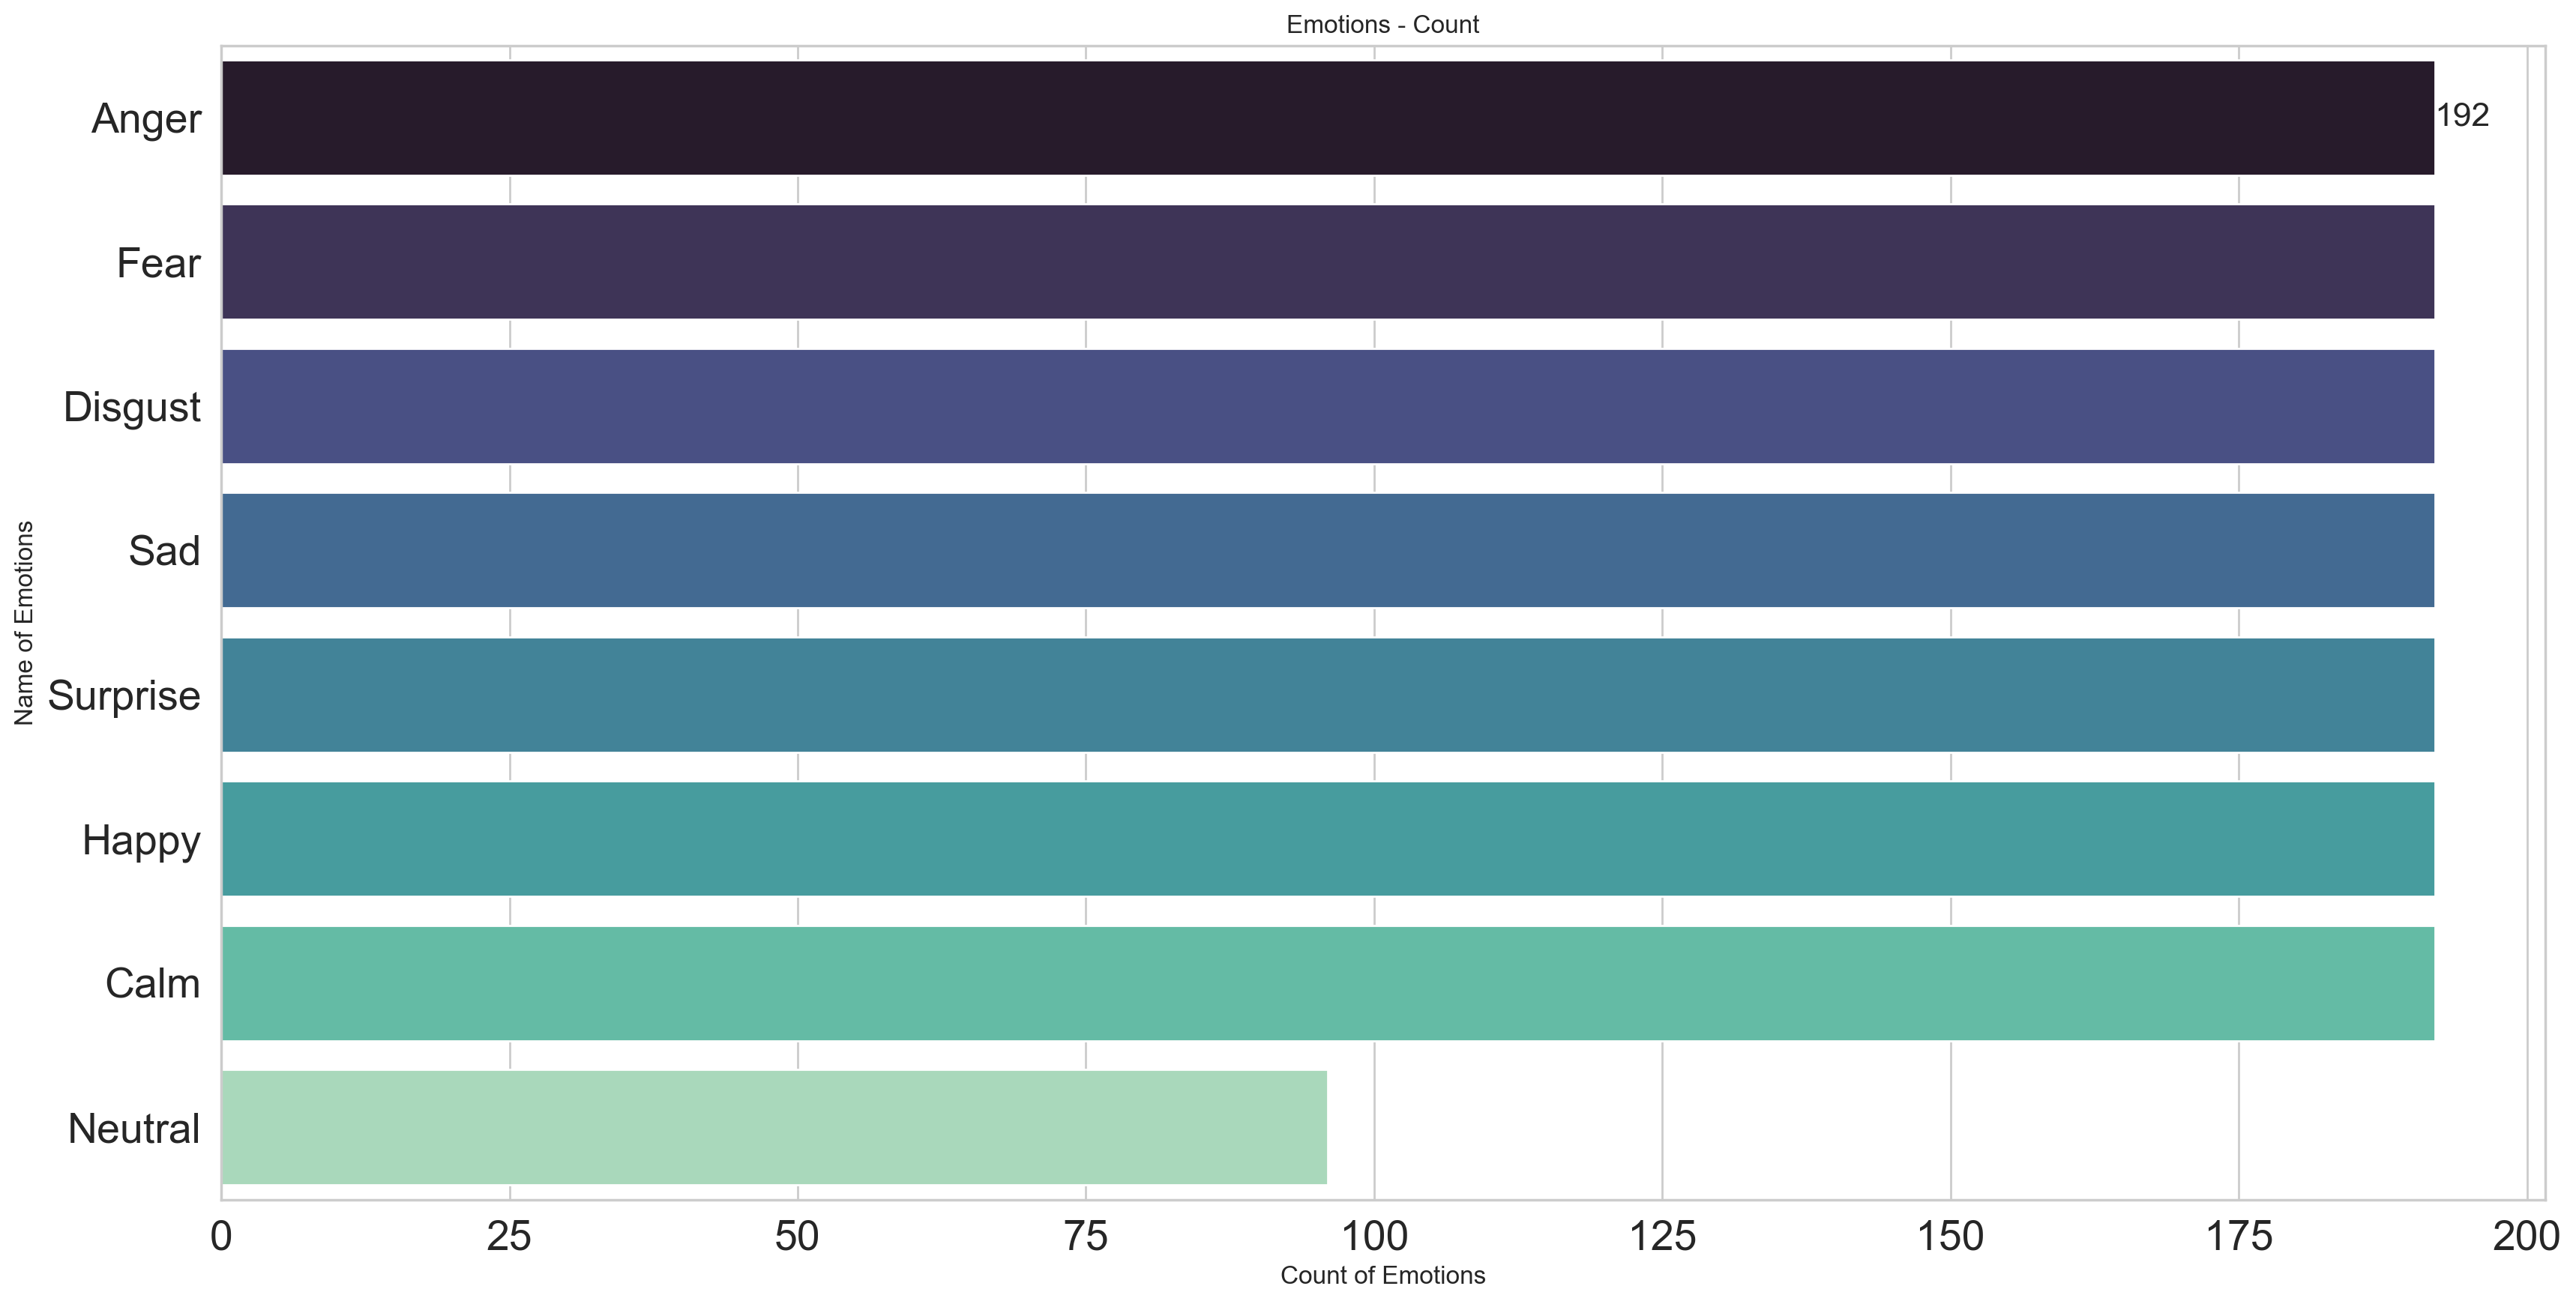

In [15]:
sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(20,10),dpi=200)
Count_emotion = Ravdess_df['Emotions'].value_counts()[:]
ax = sns.barplot(x= Count_emotion, y= Count_emotion.index, palette="mako")
ax.bar_label(ax.containers[0],fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Name of Emotions")
plt.xlabel("Count of Emotions")
plt.title("Emotions - Count")
plt.show()

## Savee

In [16]:
Ex_Savee_dir_list = Savee_dir_list[:15]
Ex_Savee_dir_list

['JK_sa01.wav',
 'JK_sa15.wav',
 'DC_n13.wav',
 'DC_su09.wav',
 'DC_n07.wav',
 'JK_n20.wav',
 'JK_n08.wav',
 'JE_sa08.wav',
 'JK_f15.wav',
 'JK_f01.wav',
 'KL_sa13.wav',
 'KL_sa07.wav',
 'JK_d03.wav',
 'DC_h01.wav',
 'DC_h15.wav']

In [17]:
emotions_savee = []
path_savee = []

for it in Savee_dir_list:
    path_savee.append(Savee_path + it)
    part = it.split('_')[1]
    part = part[:-6]
    if part == 'a':
        emotions_savee.append('Anger')
    elif part == 'd':
        emotions_savee.append('Disgust')
    elif part == 'f':
        emotions_savee.append('Fear')
    elif part == 'h':
        emotions_savee.append('Happy')
    elif part == 'n':
        emotions_savee.append('Neutral')
    elif part == 'sa':
        emotions_savee.append('Sad')
    elif part == 'su':
        emotions_savee.append('Surprise')
        
    else:
        emotions_savee.append('Unknown')
        
# dataframe for emotion of files
emotion_savee_df = pd.DataFrame(emotions_savee, columns=['Emotions'])

# dataframe for path of files.
path_savee_df = pd.DataFrame(path_savee, columns=['Path'])
Savee_df = pd.concat([emotion_savee_df, path_savee_df], axis=1)
Savee_df.head()

Emotions                                               Path
0       Sad  ../data/kaggle/input/speech-emotion-recognitio...
1       Sad  ../data/kaggle/input/speech-emotion-recognitio...
2   Neutral  ../data/kaggle/input/speech-emotion-recognitio...
3  Surprise  ../data/kaggle/input/speech-emotion-recognitio...
4   Neutral  ../data/kaggle/input/speech-emotion-recognitio...

In [18]:
[Savee_df["Emotions"].unique().tolist() for i in Savee_df.columns]

[['Sad', 'Neutral', 'Surprise', 'Fear', 'Disgust', 'Happy', 'Anger'],
 ['Sad', 'Neutral', 'Surprise', 'Fear', 'Disgust', 'Happy', 'Anger']]

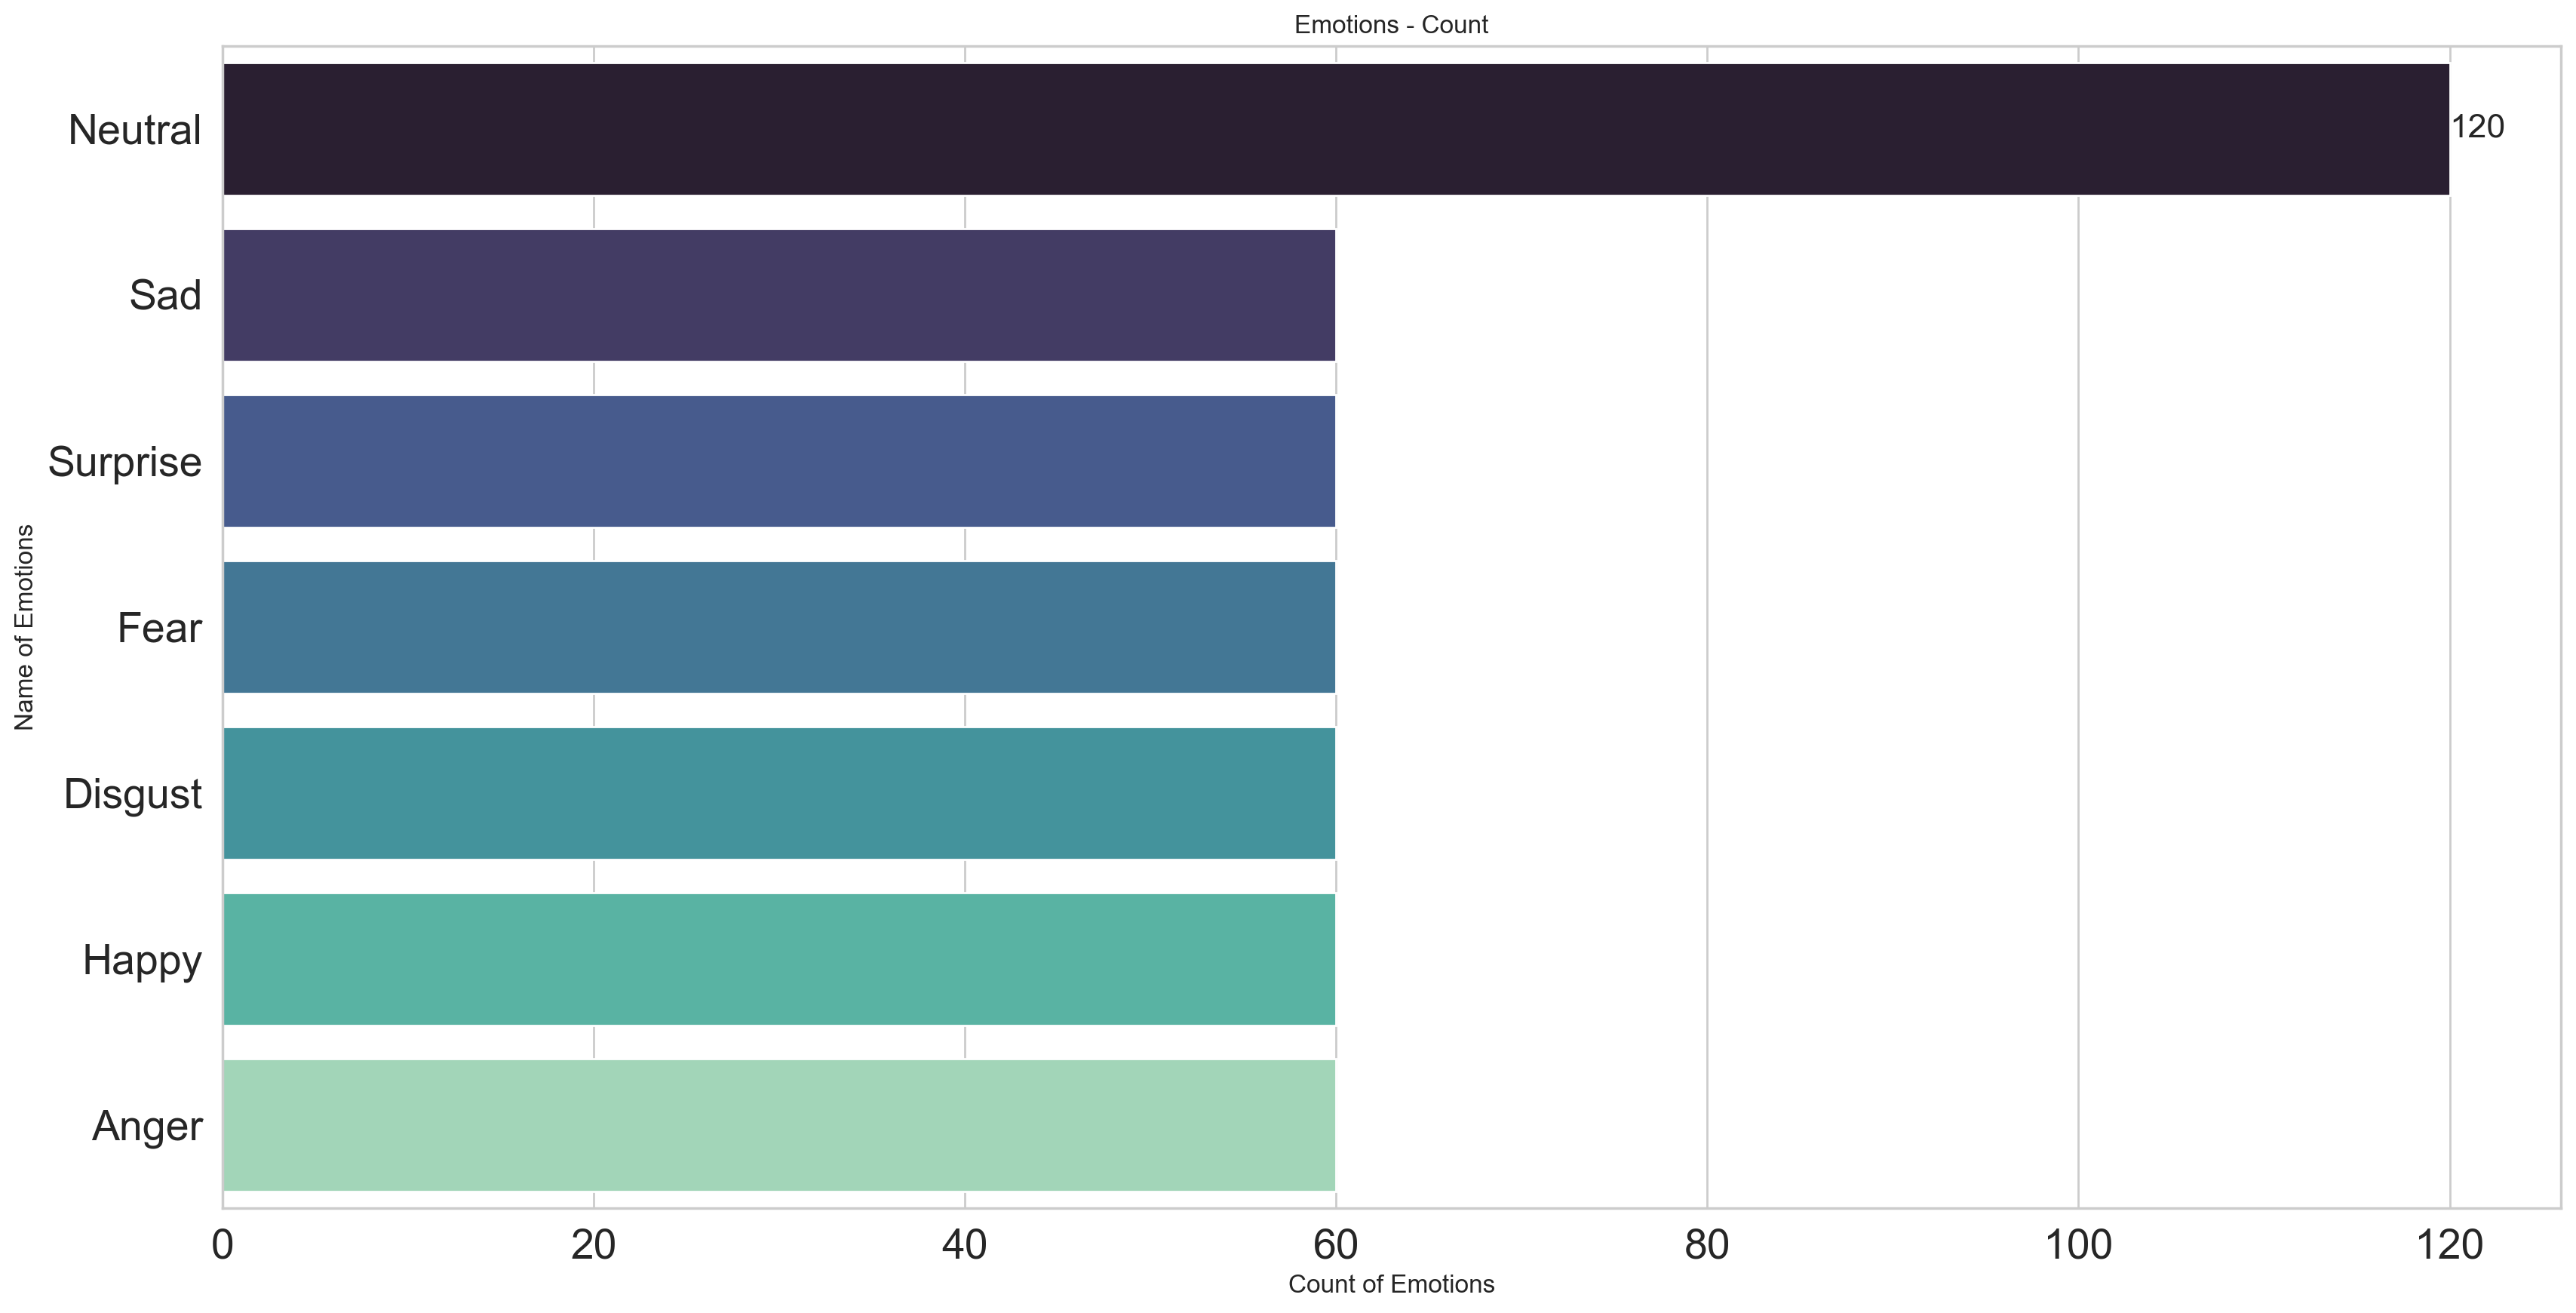

In [19]:
sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(20,10),dpi=200)
Count_emotion = Savee_df['Emotions'].value_counts()[:]
ax = sns.barplot(x= Count_emotion, y= Count_emotion.index, palette="mako")
ax.bar_label(ax.containers[0],fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Name of Emotions")
plt.xlabel("Count of Emotions")
plt.title("Emotions - Count")
plt.show()

In [20]:
Ex_Tess_dir_list = Tess_dir_list[:15]
Ex_Tess_dir_list

['YAF_disgust',
 'OAF_Pleasant_surprise',
 '.DS_Store',
 'OAF_happy',
 'YAF_sad',
 'YAF_happy',
 'YAF_neutral',
 'OAF_Fear',
 'OAF_angry',
 'YAF_pleasant_surprised',
 'YAF_fear',
 'OAF_neutral',
 'OAF_disgust',
 'YAF_angry',
 'OAF_Sad']

## Tess

In [21]:
emotions_tess = []
path_tess = []

for it in Tess_dir_list:
    path = f"{Tess_path}/{it}"
    if os.path.isdir(path):
        directories = os.listdir(path)
        for file in directories:
            file_class = file.split('_')[2].split(".")[0]
            if file_class=='ps':
                emotions_tess.append('Surprise')
            elif file_class == 'disgust':
                emotions_tess.append('Disgust')
            elif file_class == 'happy':
                emotions_tess.append('Happy')
            elif file_class == 'sad':
                emotions_tess.append('Sad')
            elif file_class == 'neutral':
                emotions_tess.append('Neutral')
            elif file_class == 'fear':
                emotions_tess.append('Fear')
            elif file_class == 'angry':
                emotions_tess.append('Anger')
            else:
                emotions_tess.append(file_class)
                
            path_tess.append(f"{Tess_path}/{it}/{file}")
            
        
        
# dataframe for emotion of files
emotion_tess_df = pd.DataFrame(emotions_tess, columns=['Emotions'])

# dataframe for path of files.
path_tess_df = pd.DataFrame(path_tess, columns=['Path'])
Tess_df = pd.concat([emotion_tess_df, path_tess_df], axis=1)
Tess_df.head()

Emotions                                               Path
0  Disgust  ../data/kaggle/input/speech-emotion-recognitio...
1  Disgust  ../data/kaggle/input/speech-emotion-recognitio...
2  Disgust  ../data/kaggle/input/speech-emotion-recognitio...
3  Disgust  ../data/kaggle/input/speech-emotion-recognitio...
4  Disgust  ../data/kaggle/input/speech-emotion-recognitio...

In [22]:
[Tess_df["Emotions"].unique().tolist() for i in Tess_df.columns]

[['Disgust', 'Surprise', 'Happy', 'Sad', 'Neutral', 'Fear', 'Anger'],
 ['Disgust', 'Surprise', 'Happy', 'Sad', 'Neutral', 'Fear', 'Anger']]

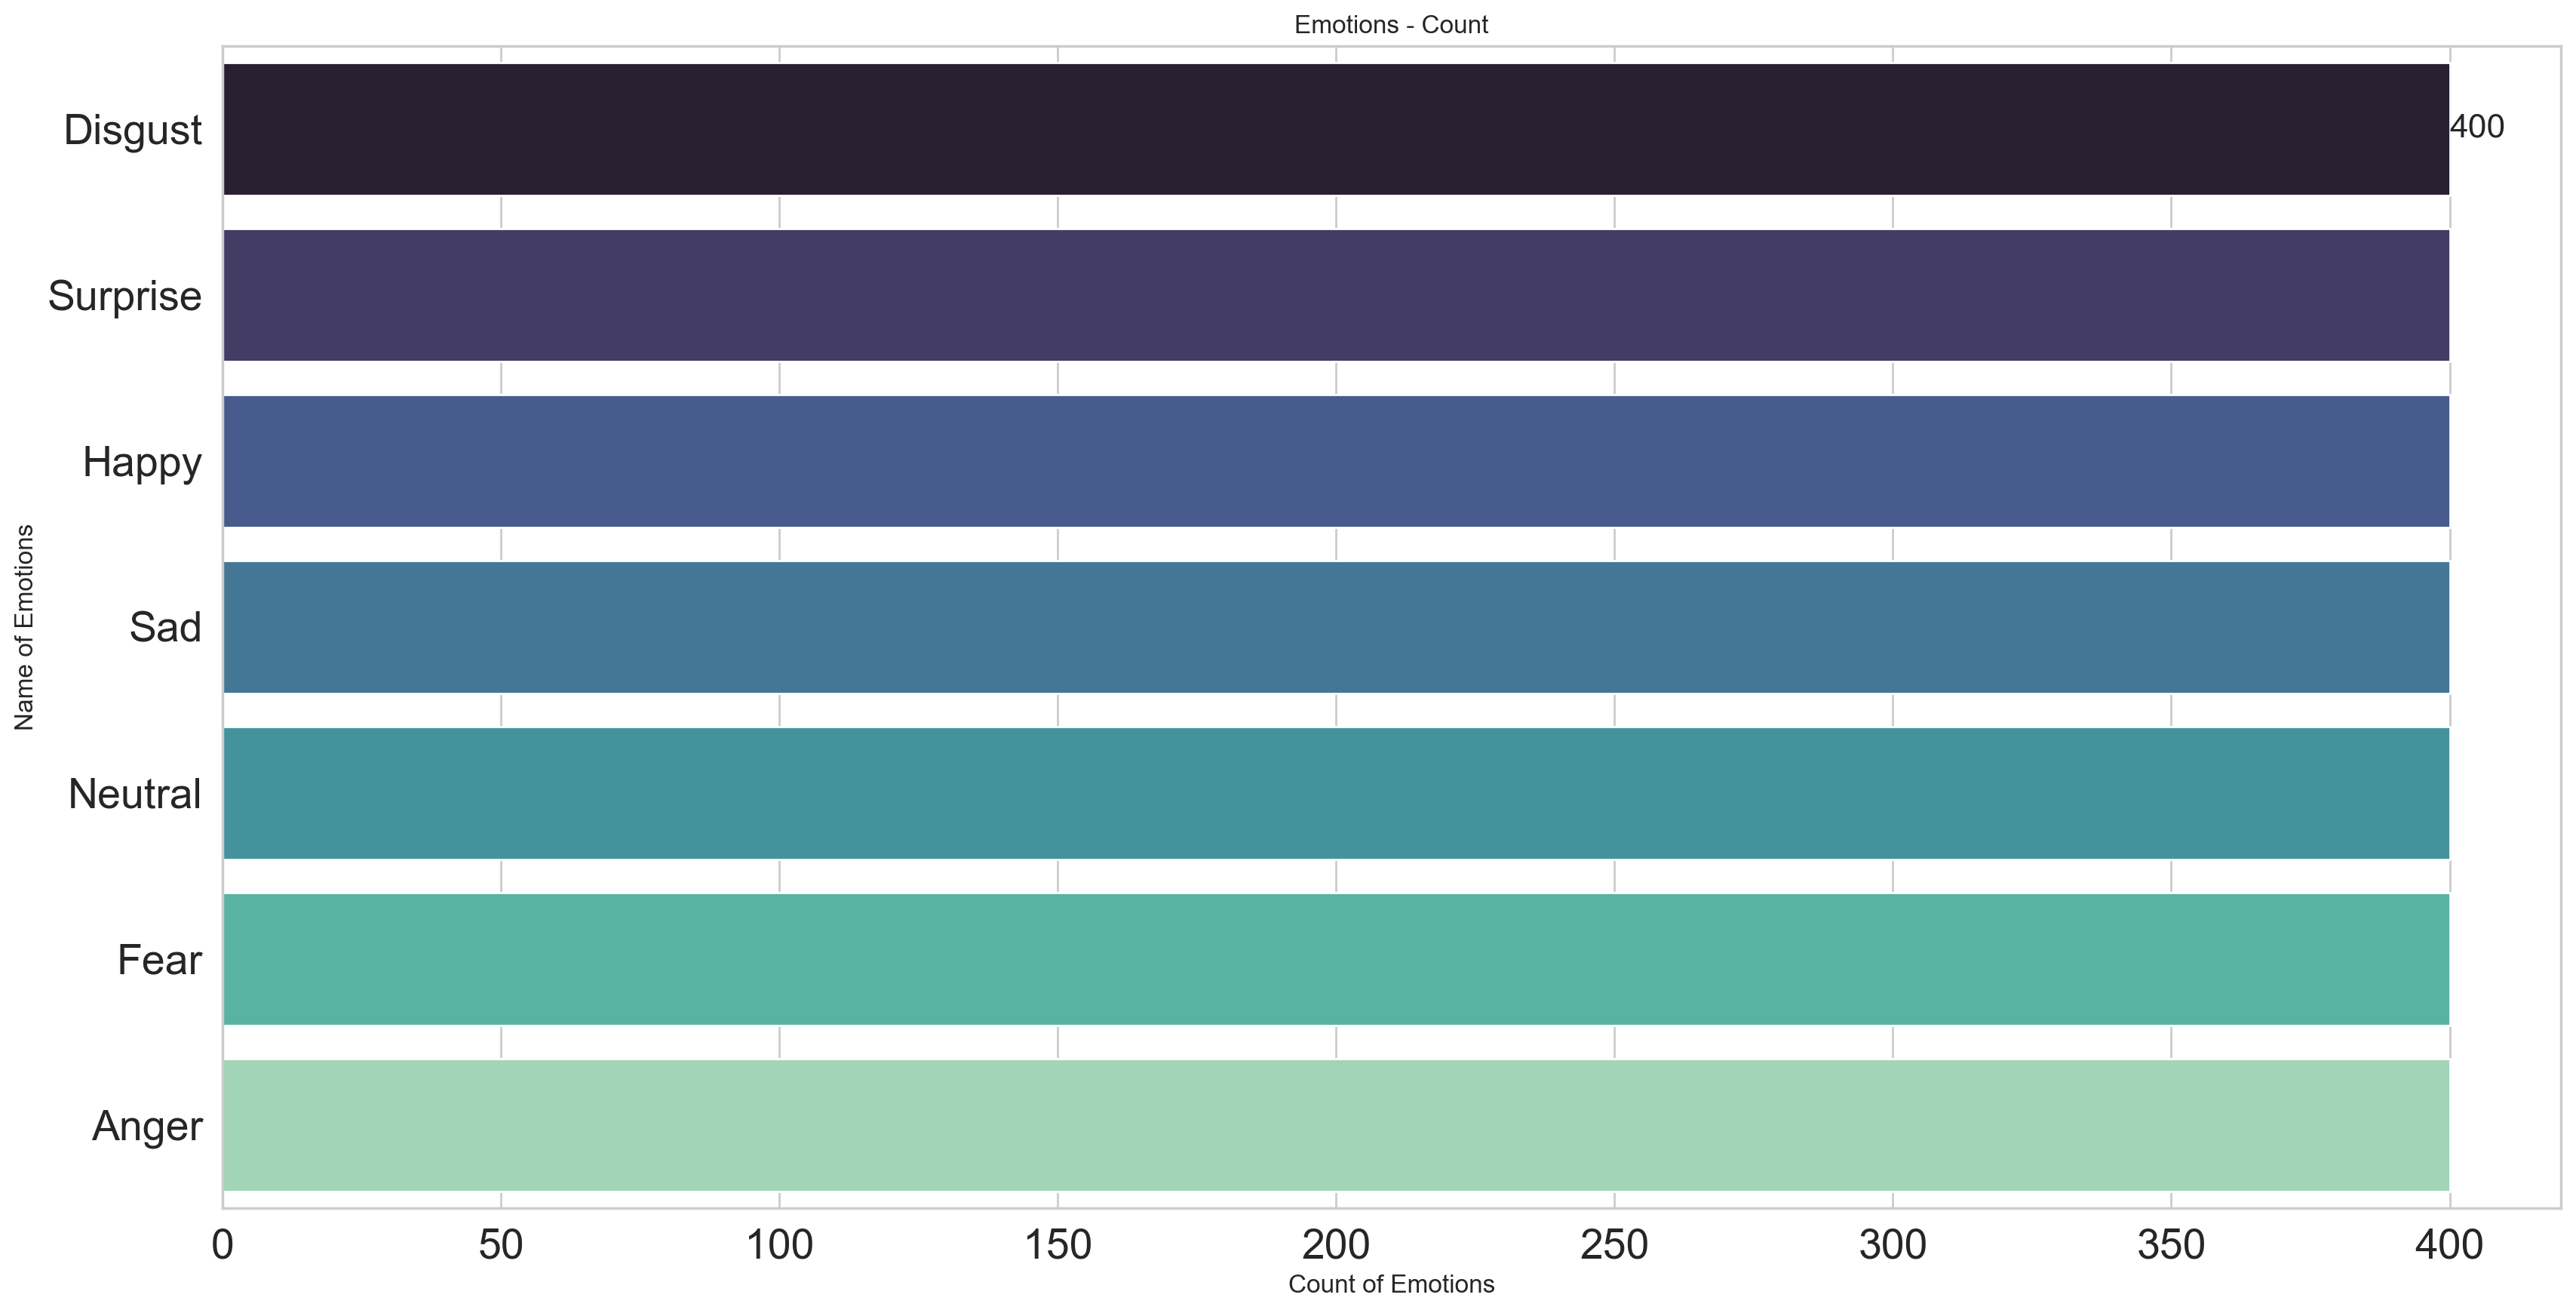

In [23]:
sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(20,10),dpi=200)
Count_emotion = Tess_df['Emotions'].value_counts()[:]
ax = sns.barplot(x= Count_emotion, y= Count_emotion.index, palette="mako")
ax.bar_label(ax.containers[0],fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Name of Emotions")
plt.xlabel("Count of Emotions")
plt.title("Emotions - Count")
plt.show()

In [24]:
Sum_df = pd.concat([Crema_df, Ravdess_df, Savee_df, Tess_df], axis = 0)
Sum_df.to_csv("Sum_df.csv",index=False)
Sum_df.head()

Emotions                                               Path
0    Anger  ../data/kaggle/input/speech-emotion-recognitio...
1    Anger  ../data/kaggle/input/speech-emotion-recognitio...
2  Neutral  ../data/kaggle/input/speech-emotion-recognitio...
3  Neutral  ../data/kaggle/input/speech-emotion-recognitio...
4  Disgust  ../data/kaggle/input/speech-emotion-recognitio...

In [25]:
[Sum_df["Emotions"].unique().tolist() for i in Sum_df.columns]

[['Anger', 'Neutral', 'Disgust', 'Sad', 'Fear', 'Happy', 'Surprise', 'Calm'],
 ['Anger', 'Neutral', 'Disgust', 'Sad', 'Fear', 'Happy', 'Surprise', 'Calm']]

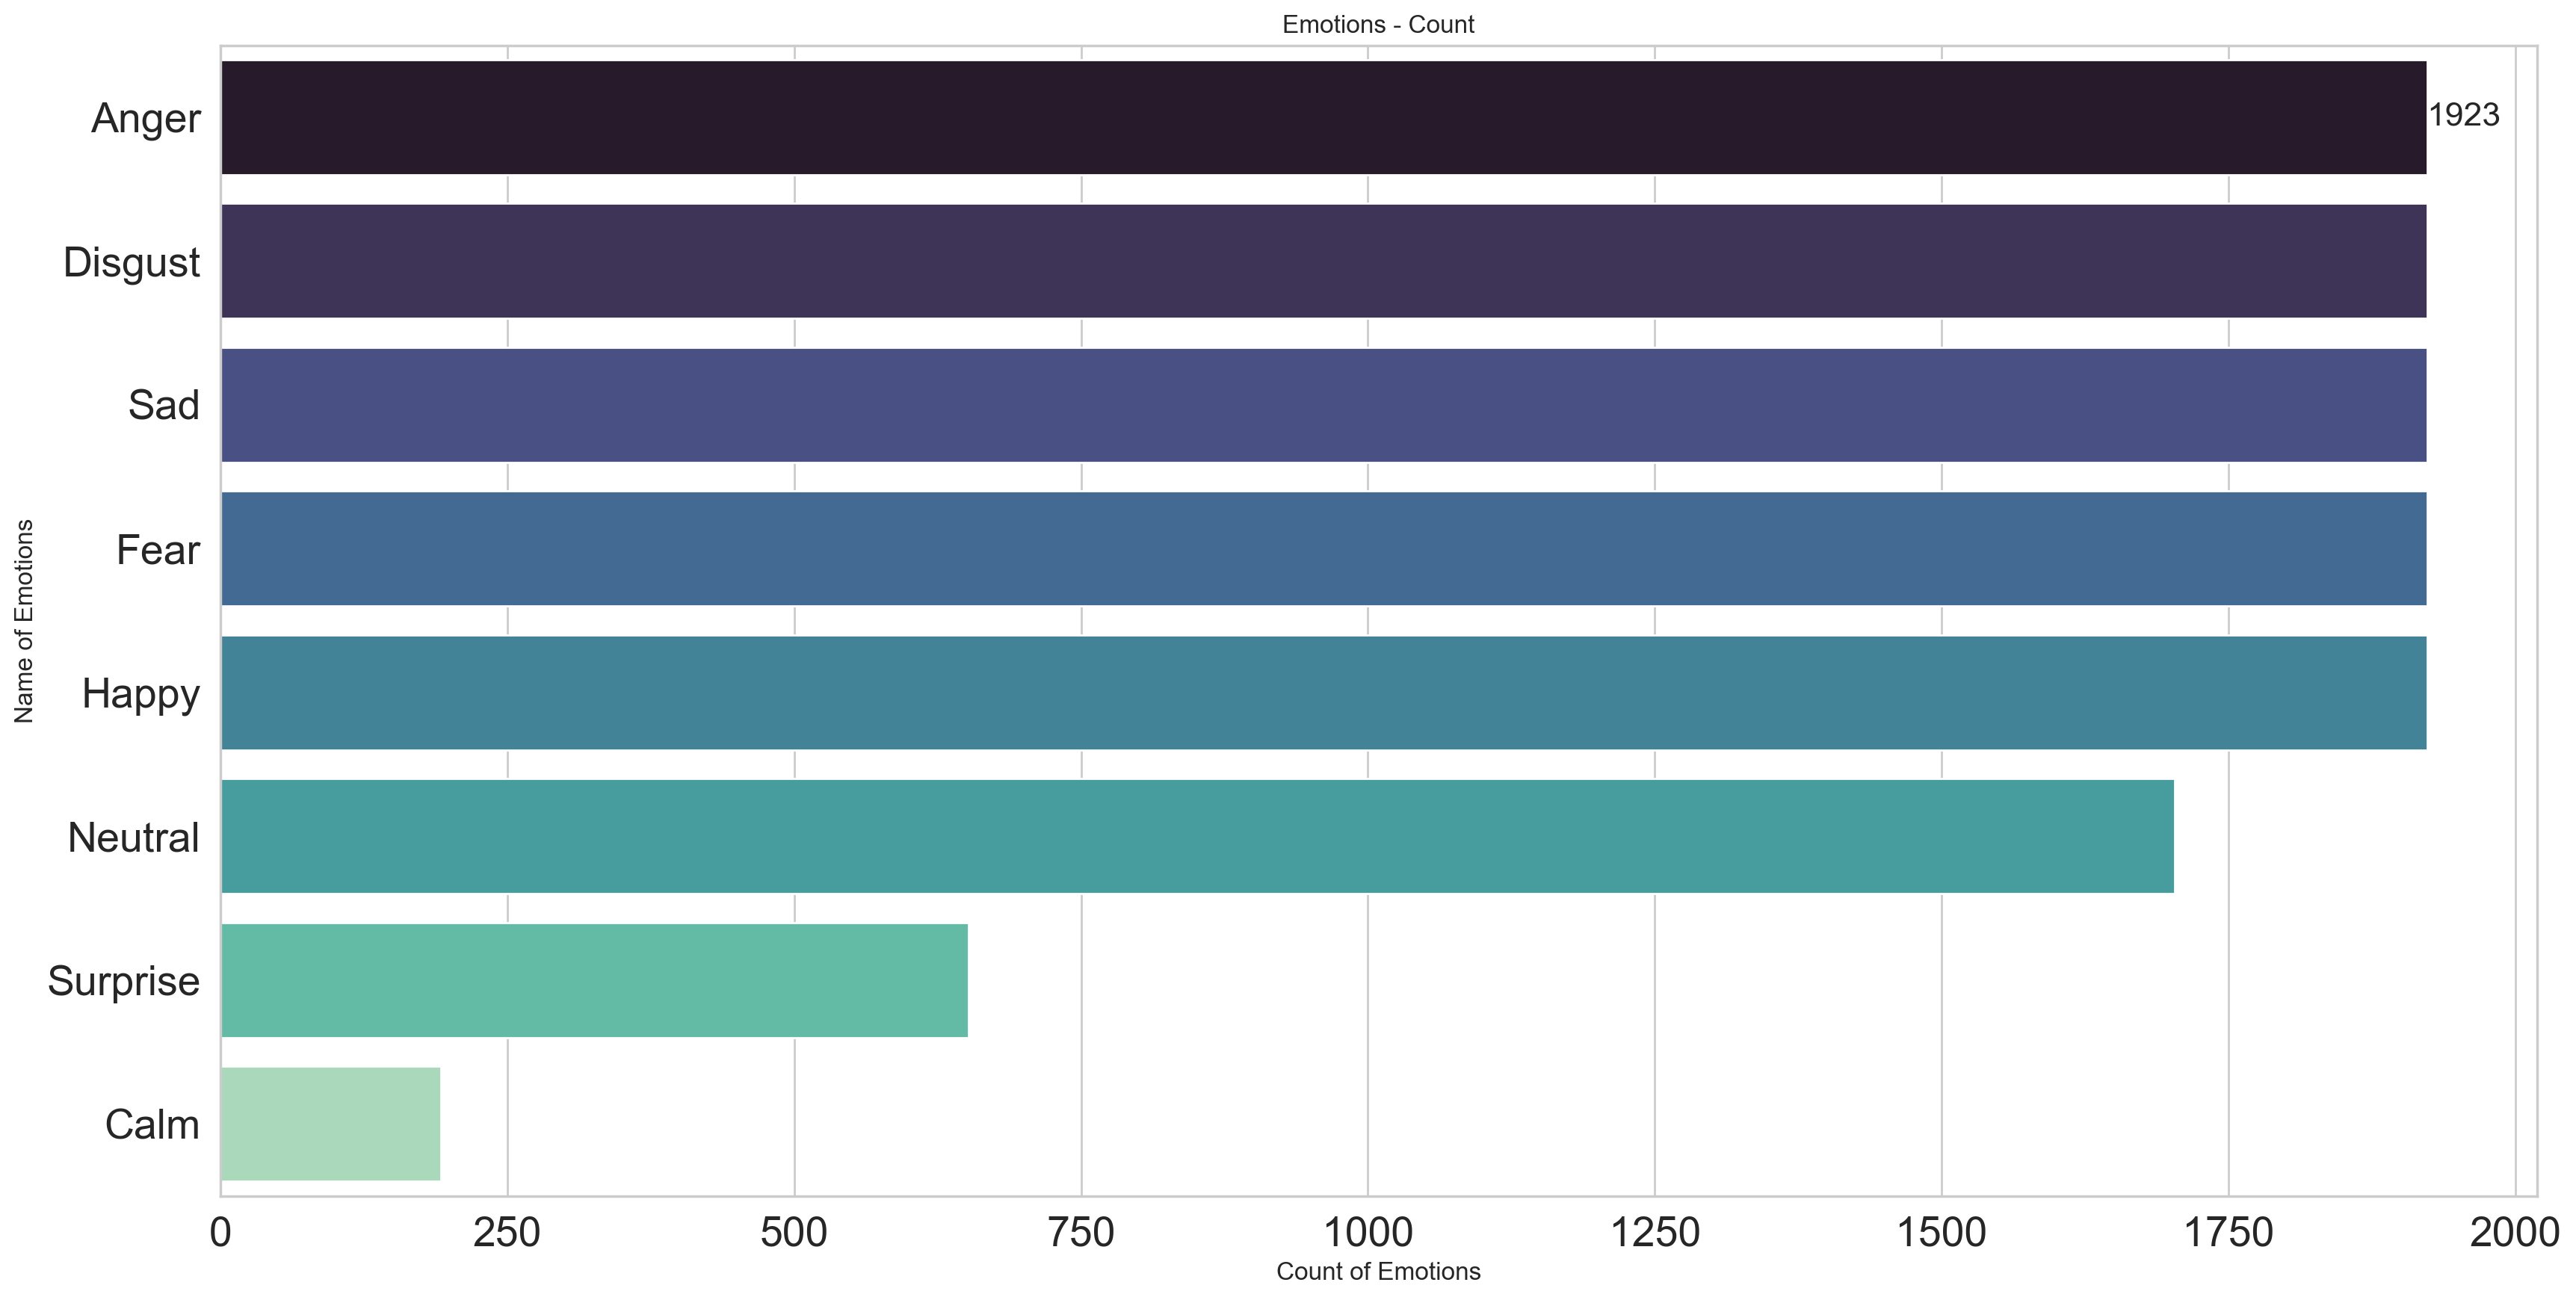

In [26]:
sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(20,10),dpi=200)
Count_emotion = Sum_df['Emotions'].value_counts()[:]
ax = sns.barplot(x= Count_emotion, y= Count_emotion.index, palette="mako")
ax.bar_label(ax.containers[0],fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Name of Emotions")
plt.xlabel("Count of Emotions")
plt.title("Emotions - Count")
plt.show()

In [27]:
Sum_df_rep = Sum_df
Sum_df_rep['Emotions'].replace('happiness', 'happy', inplace=True)
Sum_df_rep['Emotions'].replace('sadness', 'sad', inplace=True)
Sum_df_rep['Emotions'].replace('calm', 'neutral', inplace=True)

In [28]:
[Sum_df_rep["Emotions"].unique().tolist() for i in Sum_df_rep.columns]

[['Anger', 'Neutral', 'Disgust', 'Sad', 'Fear', 'Happy', 'Surprise', 'Calm'],
 ['Anger', 'Neutral', 'Disgust', 'Sad', 'Fear', 'Happy', 'Surprise', 'Calm']]

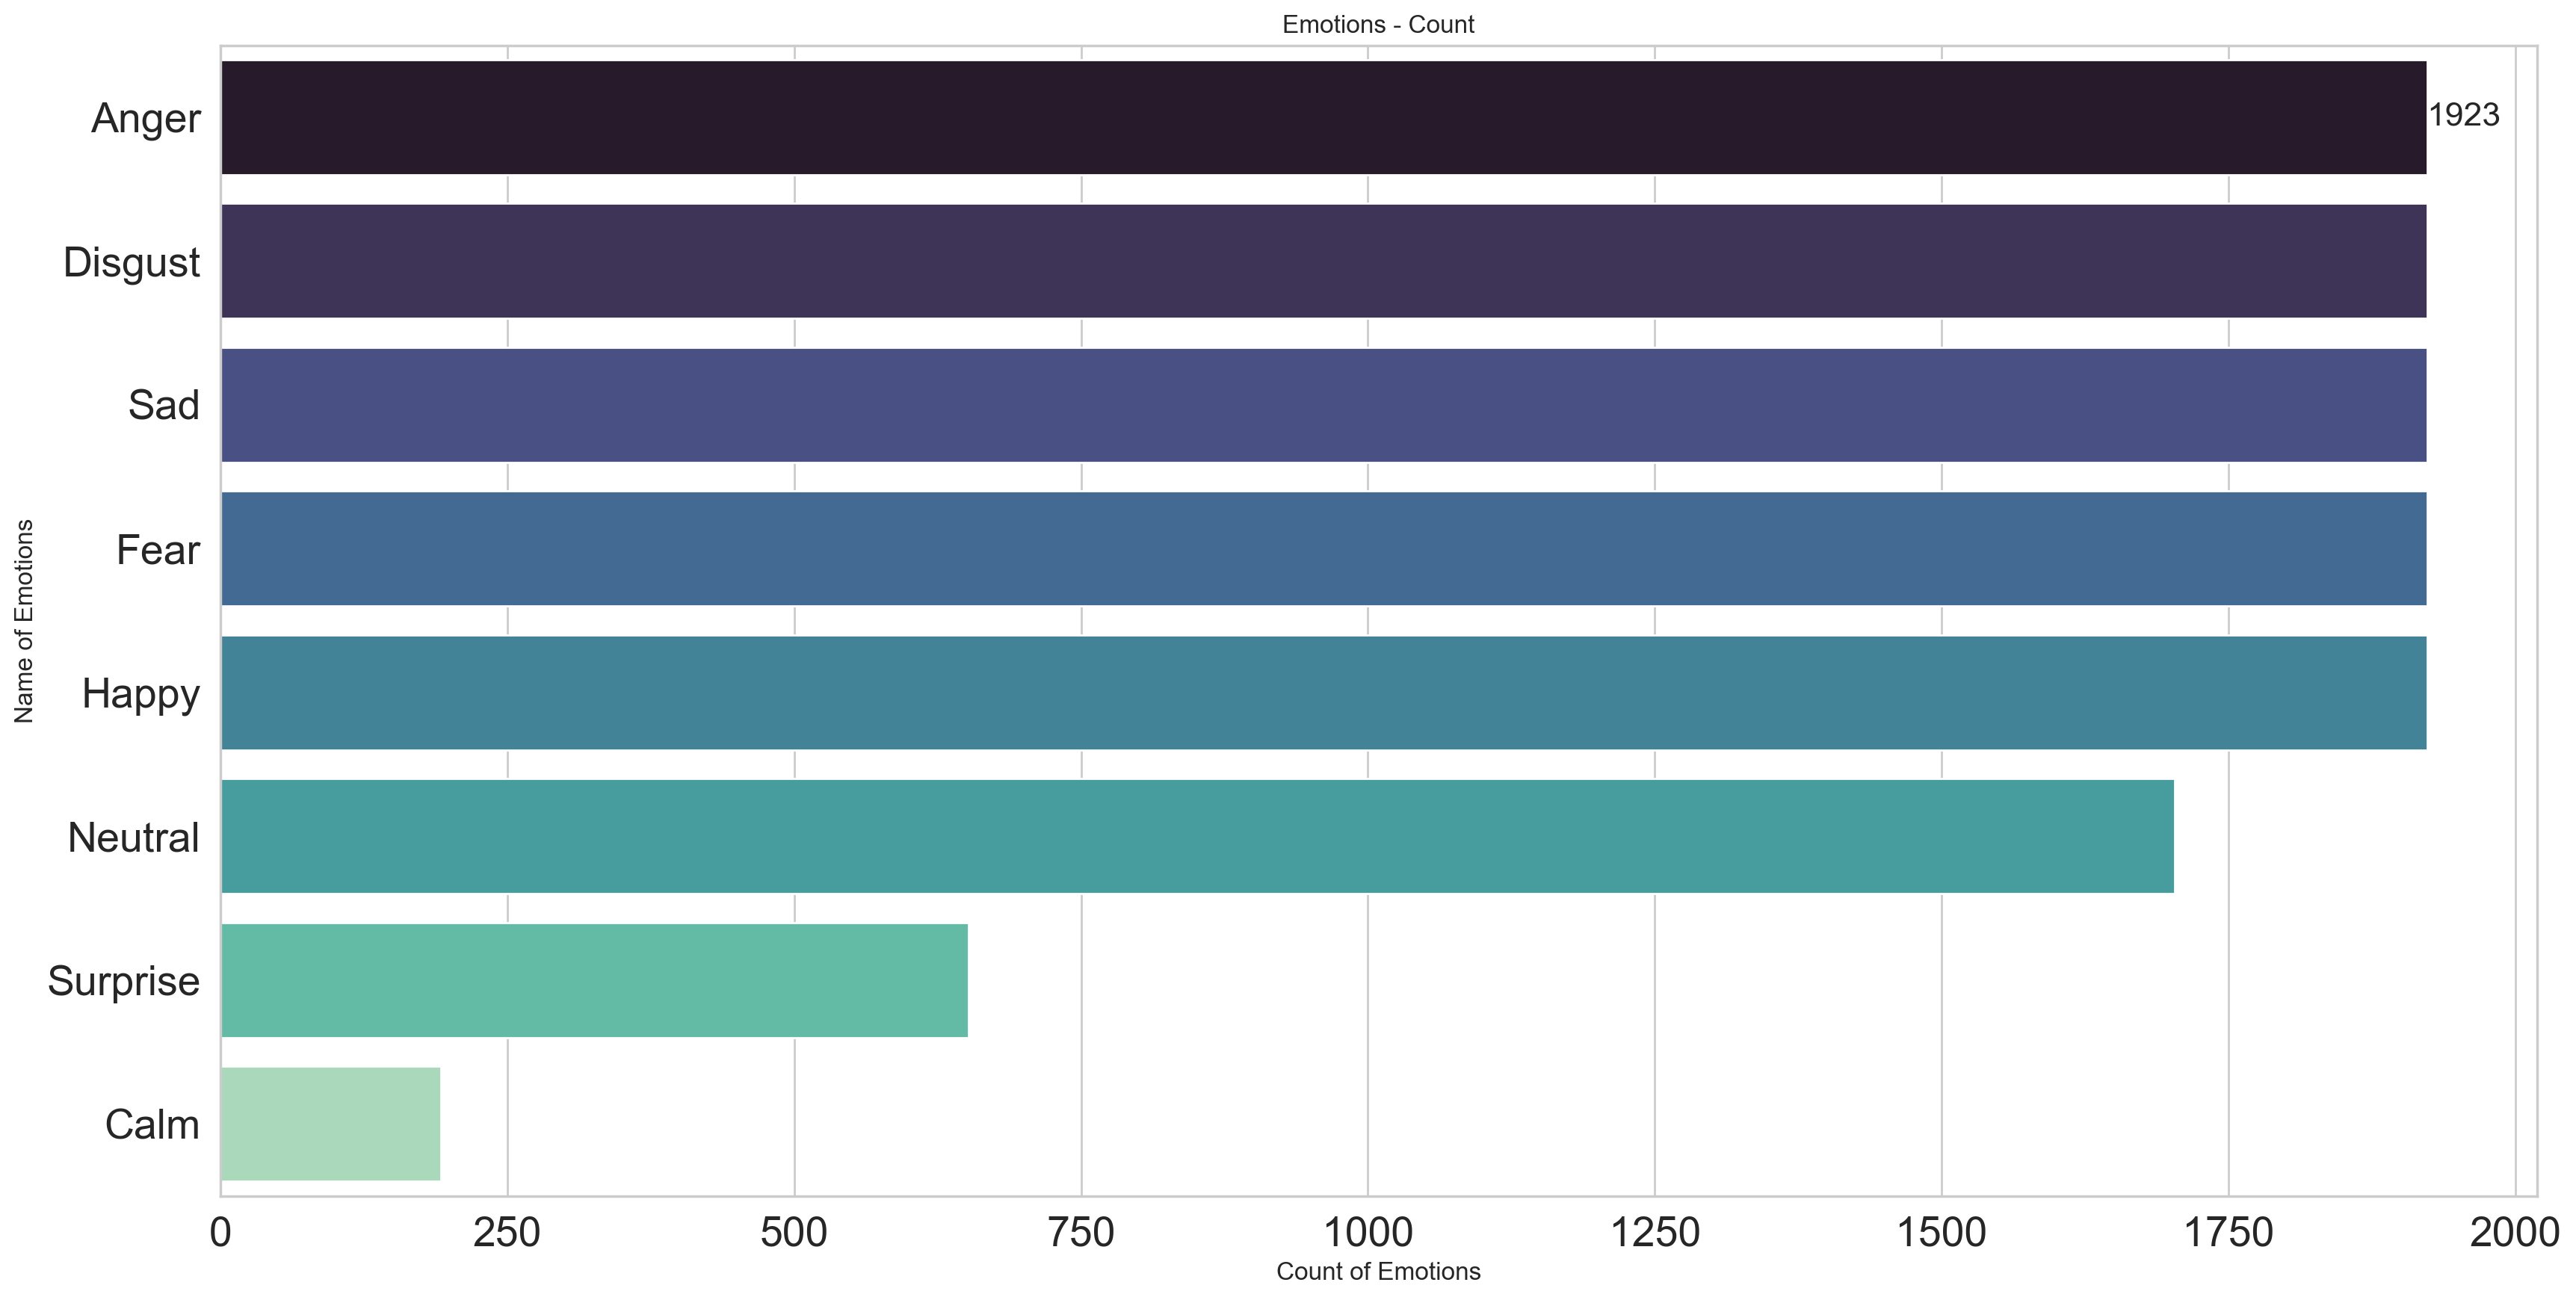

In [29]:
sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(20,10),dpi=200)
Count_emotion = Sum_df_rep['Emotions'].value_counts()[:]
ax = sns.barplot(x= Count_emotion, y= Count_emotion.index, palette="mako")
ax.bar_label(ax.containers[0],fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Name of Emotions")
plt.xlabel("Count of Emotions")
plt.title("Emotions - Count")
plt.show()

In [30]:
%%time
audio_arrays = []

for i, path in enumerate(Sum_df_rep['Path']):
    y, sr = librosa.load(path, sr=44100)
    audio_arrays.append(y)
    print(f"{i+1}/{len(Sum_df_rep)}", end="\r")
    
Sum_df_rep['Arrays'] = audio_arrays

CPU times: user 12.5 s, sys: 2.3 s, total: 14.8 s
Wall time: 21.7 s


In [31]:
Sum_df_rep.head()

Emotions                                               Path  \
0    Anger  ../data/kaggle/input/speech-emotion-recognitio...   
1    Anger  ../data/kaggle/input/speech-emotion-recognitio...   
2  Neutral  ../data/kaggle/input/speech-emotion-recognitio...   
3  Neutral  ../data/kaggle/input/speech-emotion-recognitio...   
4  Disgust  ../data/kaggle/input/speech-emotion-recognitio...   

                                              Arrays  
0  [0.00022397174, -9.429426e-05, -0.0007466104, ...  
1  [0.000112782494, 0.00013394406, 0.00010201089,...  
2  [0.0022768811, 0.0030965768, 0.0031128167, 0.0...  
3  [-0.002233105, -0.00264515, -0.00222969, -0.00...  
4  [-0.004840348, -0.0061861426, -0.0059352717, -...

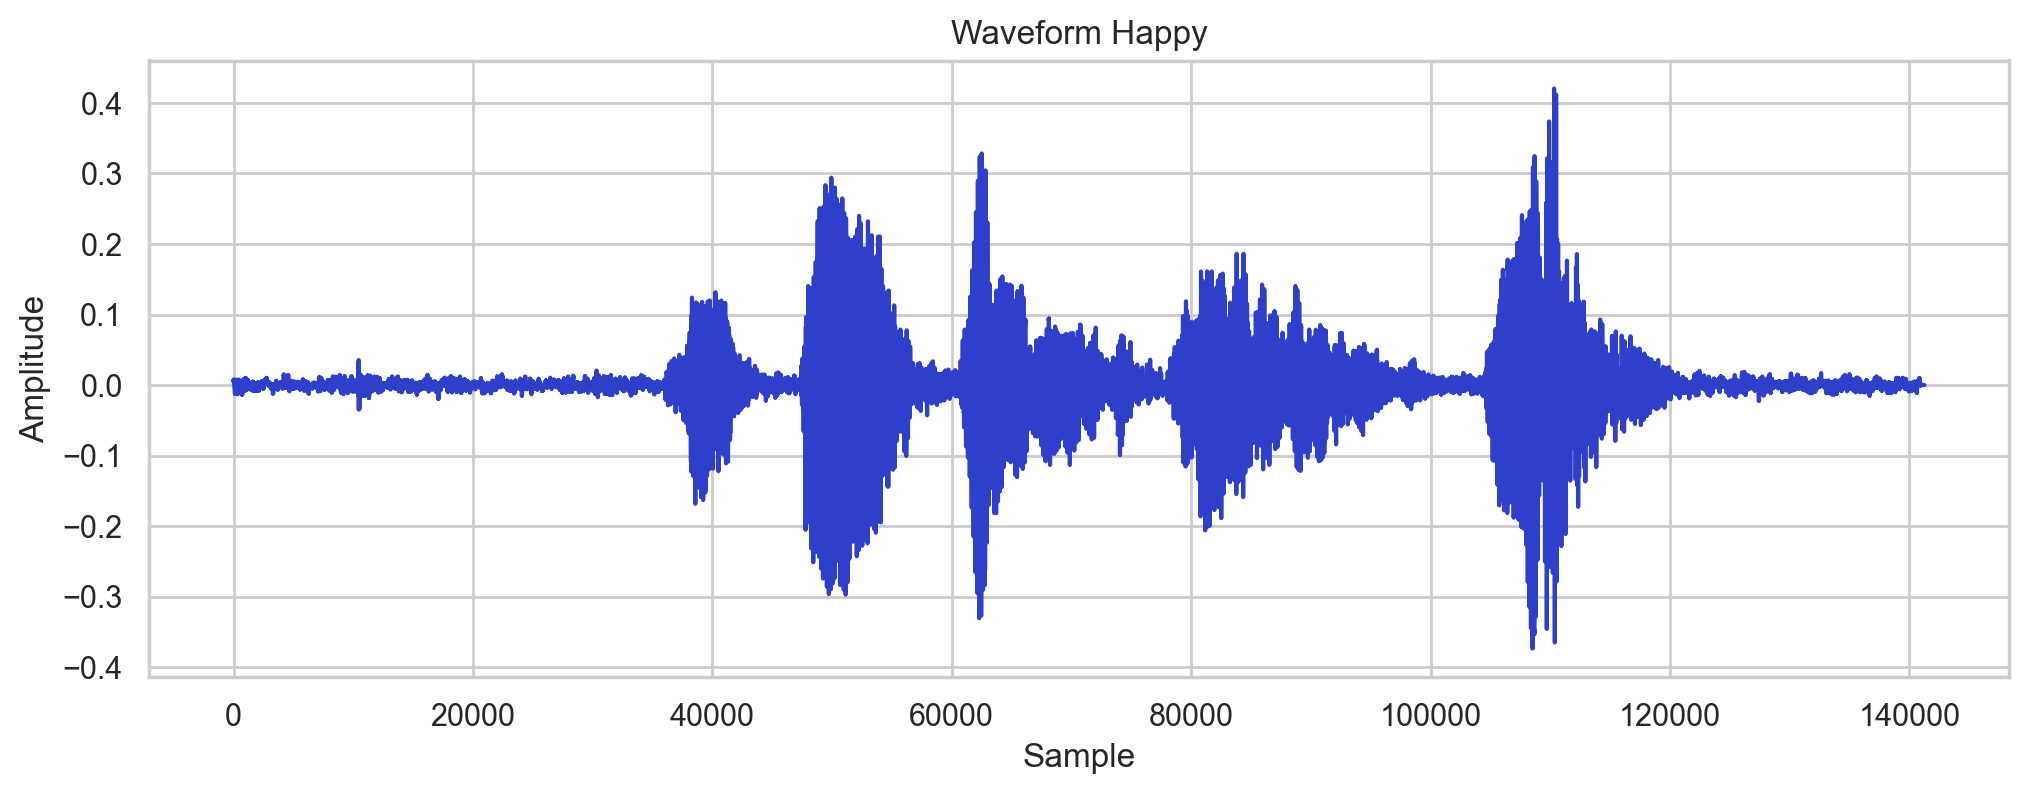

In [32]:
happy_sp = Sum_df_rep[Sum_df_rep['Emotions'] == 'Happy']['Path']
happy_arr = Sum_df_rep[Sum_df_rep['Emotions'] == 'Happy']['Arrays']

plt.figure(figsize=(12, 4), dpi=200)
plt.plot(happy_arr.iloc[0], color='#2E40CB')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Waveform Happy')
plt.show()

Audio(happy_sp.iloc[0])

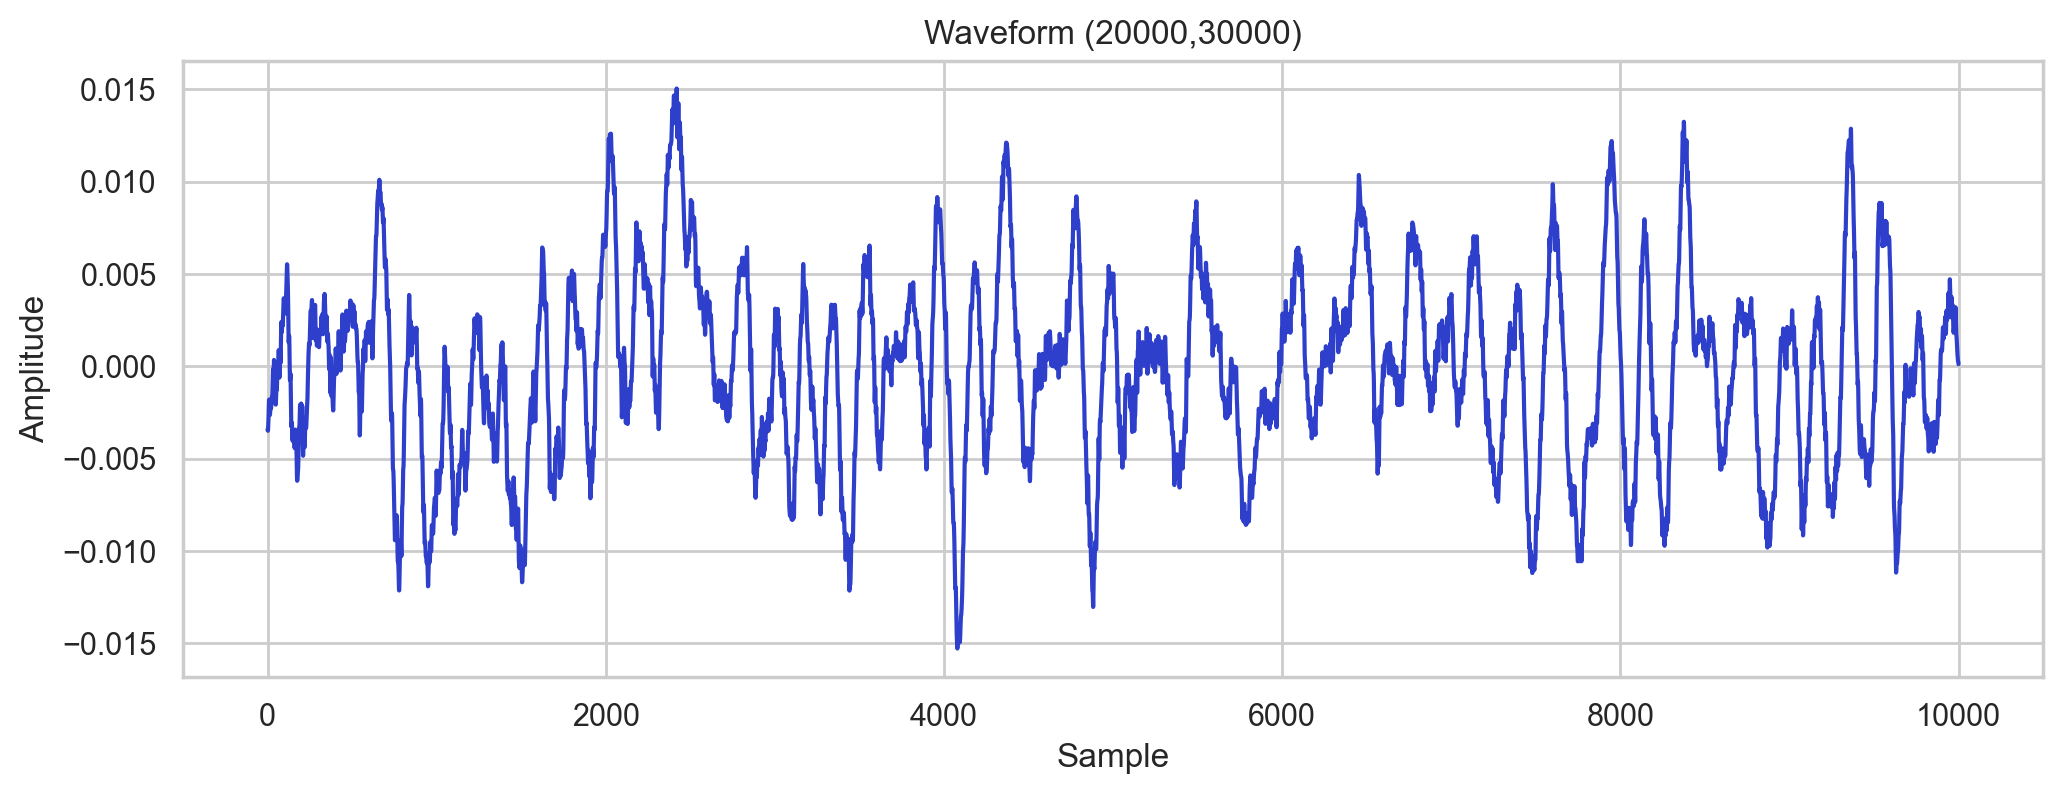

In [33]:
plt.figure(figsize=(12, 4), dpi=200)
plt.plot(happy_arr.iloc[0][20000:30000], color='#2E40CB')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Waveform (20000,30000)')
plt.show()

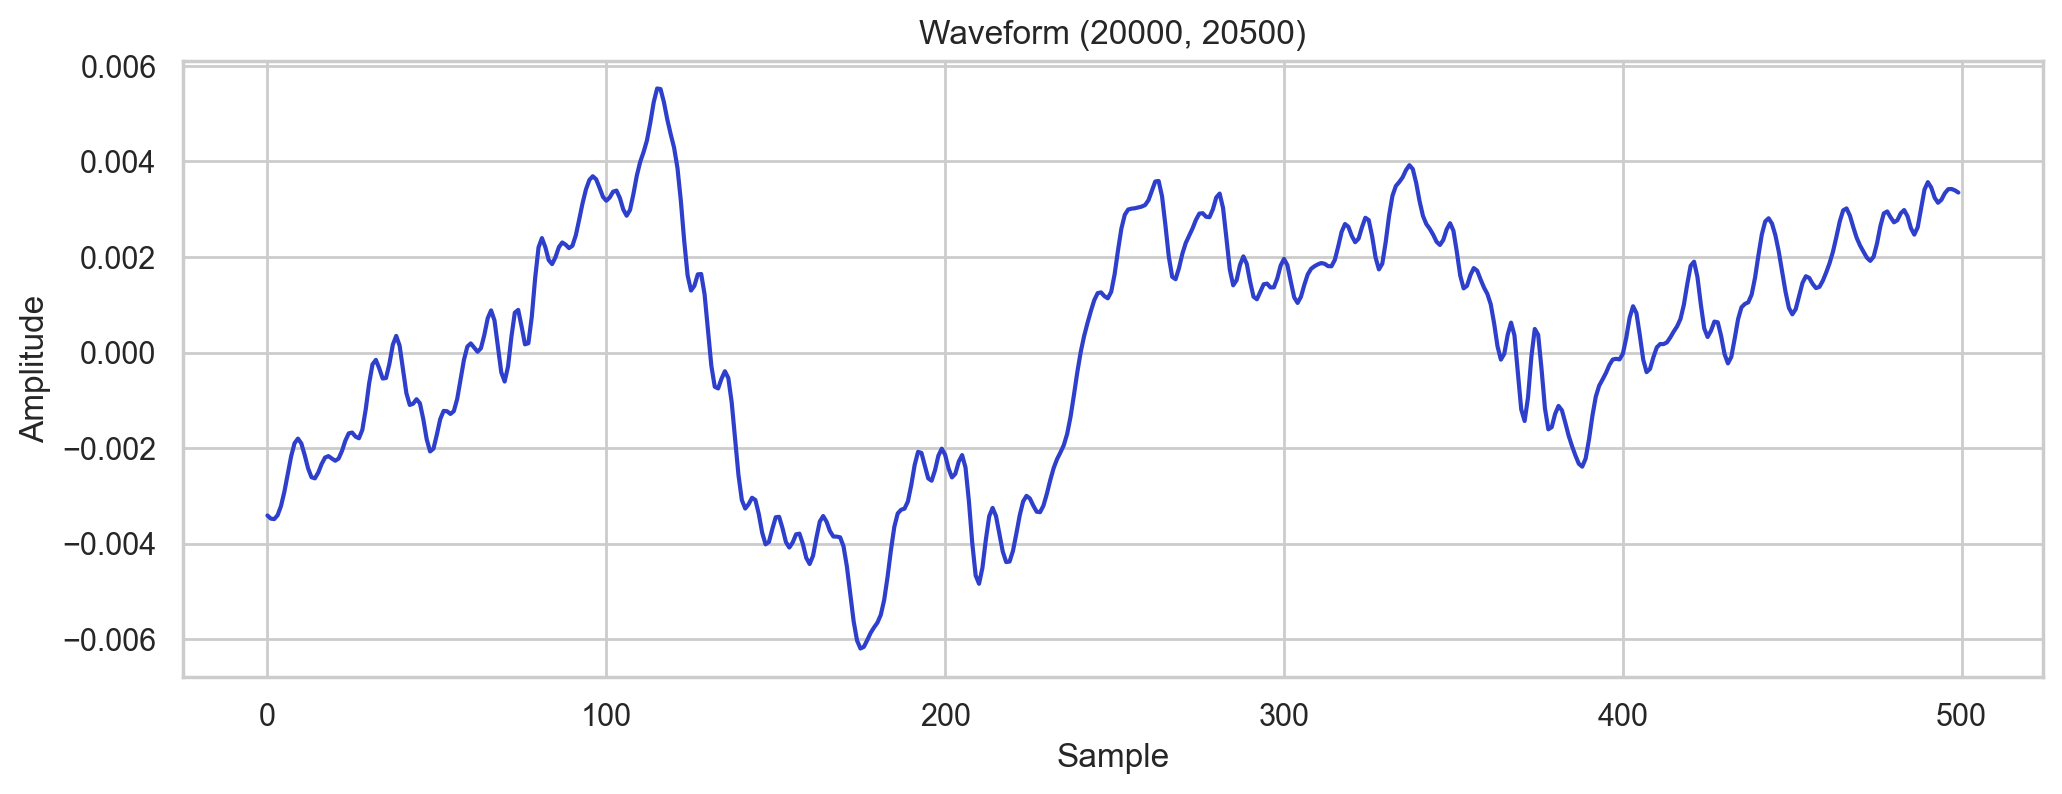

In [34]:
plt.figure(figsize=(12, 4), dpi=200)
plt.plot(happy_arr.iloc[0][20000:20500], color='#2E40CB')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Waveform (20000, 20500)')
plt.show()

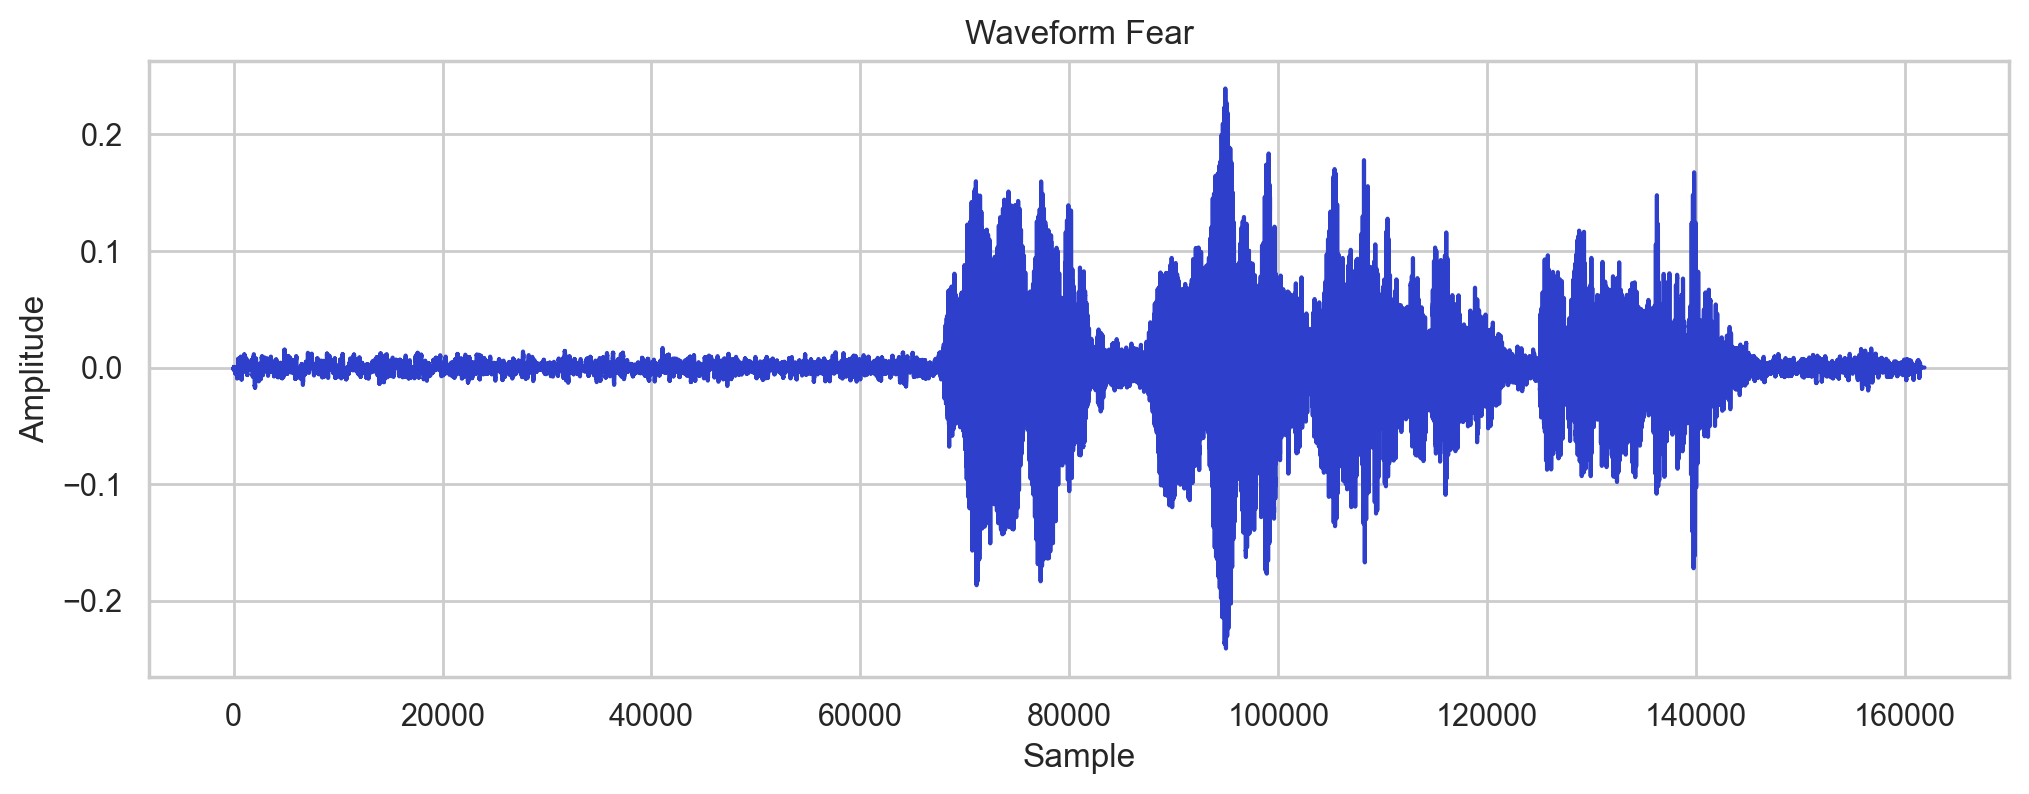

In [35]:
fear_sp = Sum_df_rep[Sum_df_rep['Emotions'] == 'Fear']['Path']
fear_arr = Sum_df_rep[Sum_df_rep['Emotions'] == 'Fear']['Arrays']

plt.figure(figsize=(12, 4), dpi=200)
plt.plot(fear_arr.iloc[0], color='#2E40CB')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Waveform Fear')
plt.show()

Audio(fear_sp.iloc[0])

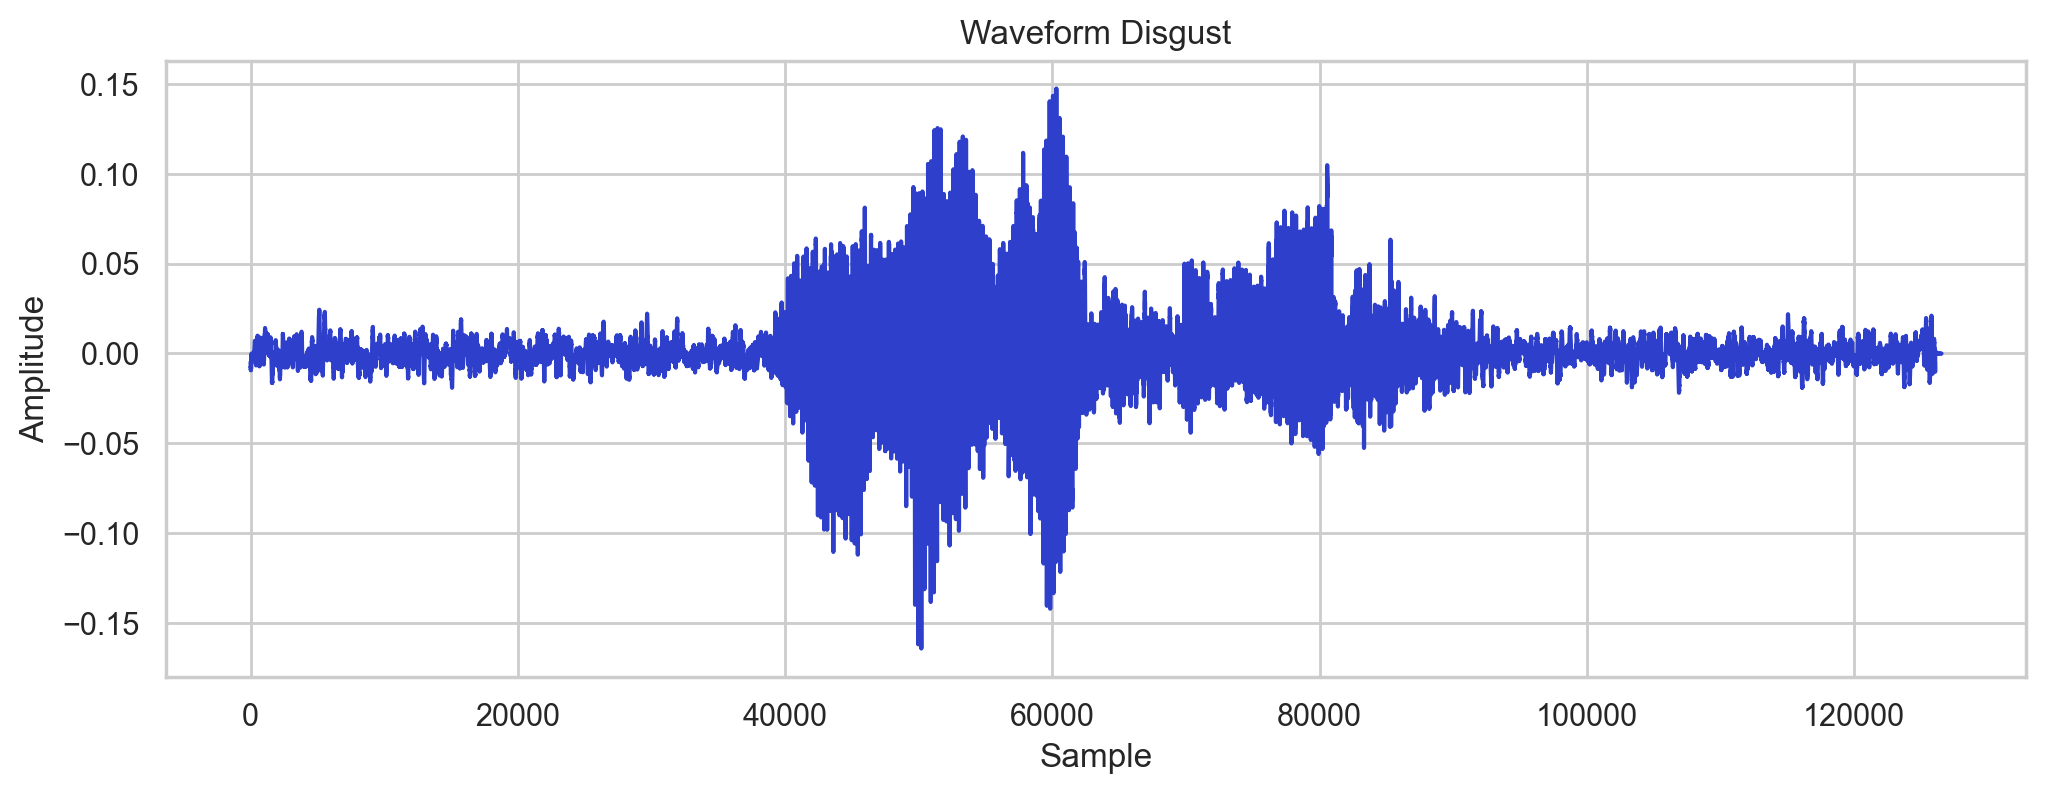

In [36]:
disgust_sp = Sum_df_rep[Sum_df_rep['Emotions'] == 'Disgust']['Path']
disgust_arr = Sum_df_rep[Sum_df_rep['Emotions'] == 'Disgust']['Arrays']

plt.figure(figsize=(12, 4), dpi=200)
plt.plot(disgust_arr.iloc[0], color='#2E40CB')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Waveform Disgust')
plt.show()

Audio(disgust_sp.iloc[0])

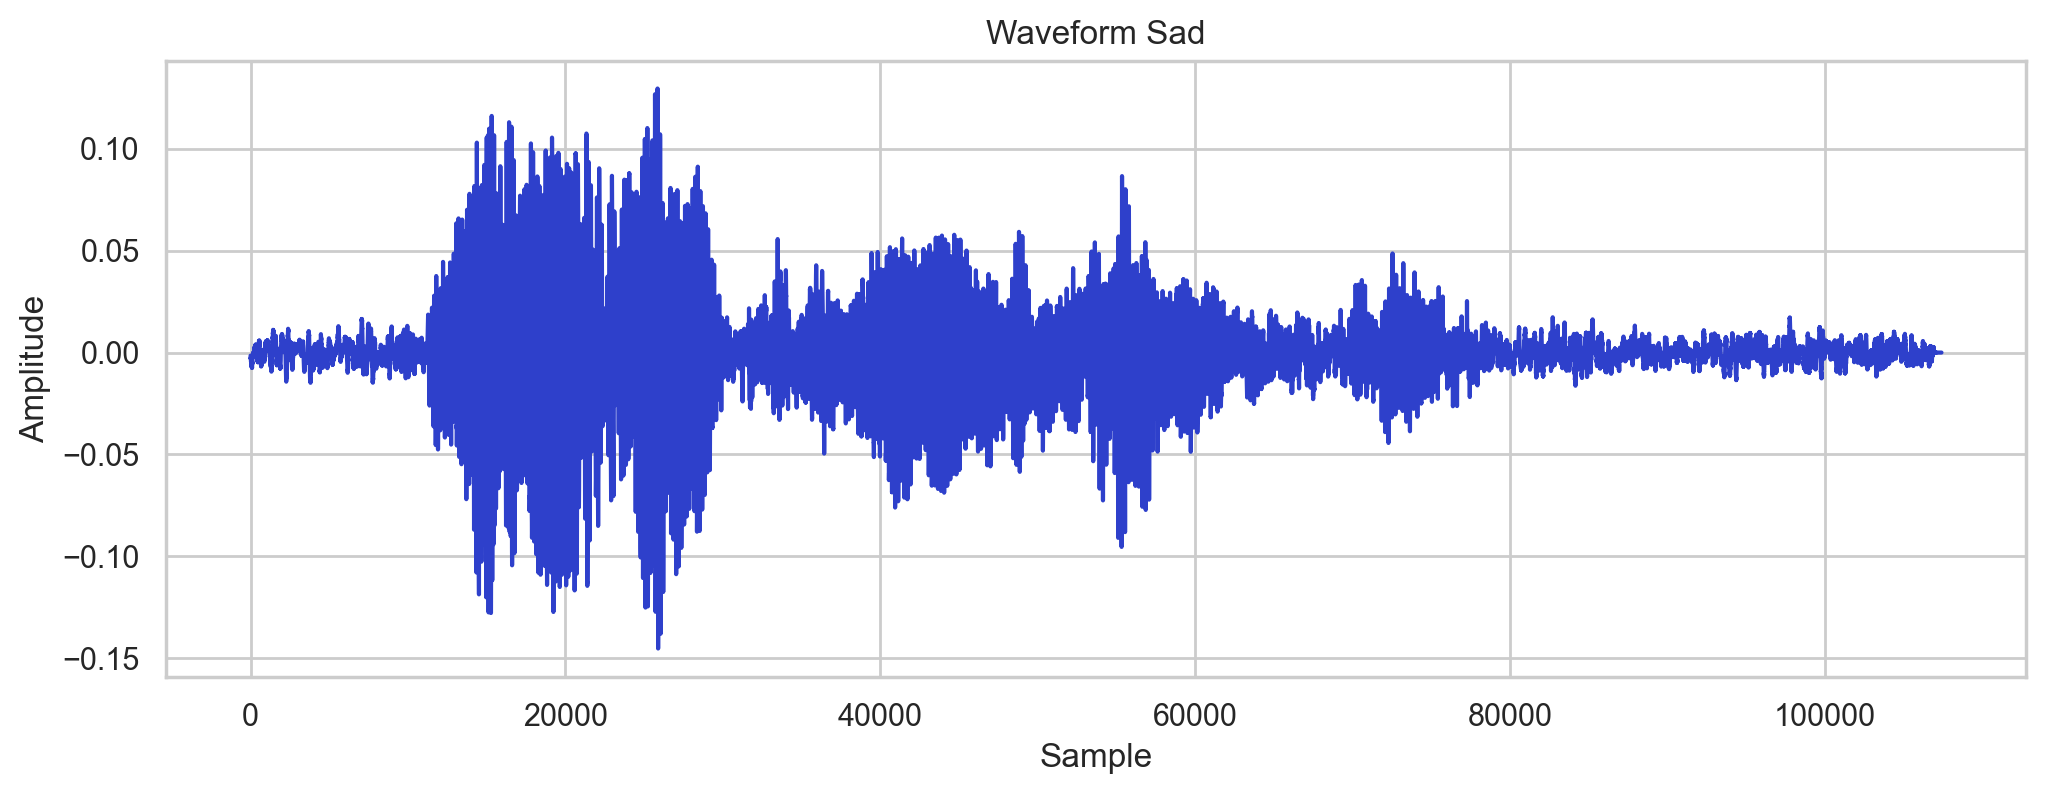

In [37]:
sad_sp = Sum_df_rep[Sum_df_rep['Emotions'] == 'Sad']['Path']
sad_arr = Sum_df_rep[Sum_df_rep['Emotions'] == 'Sad']['Arrays']

plt.figure(figsize=(12, 4), dpi=200)
plt.plot(sad_arr.iloc[0], color='#2E40CB')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Waveform Sad')
plt.show()

Audio(sad_sp.iloc[0])

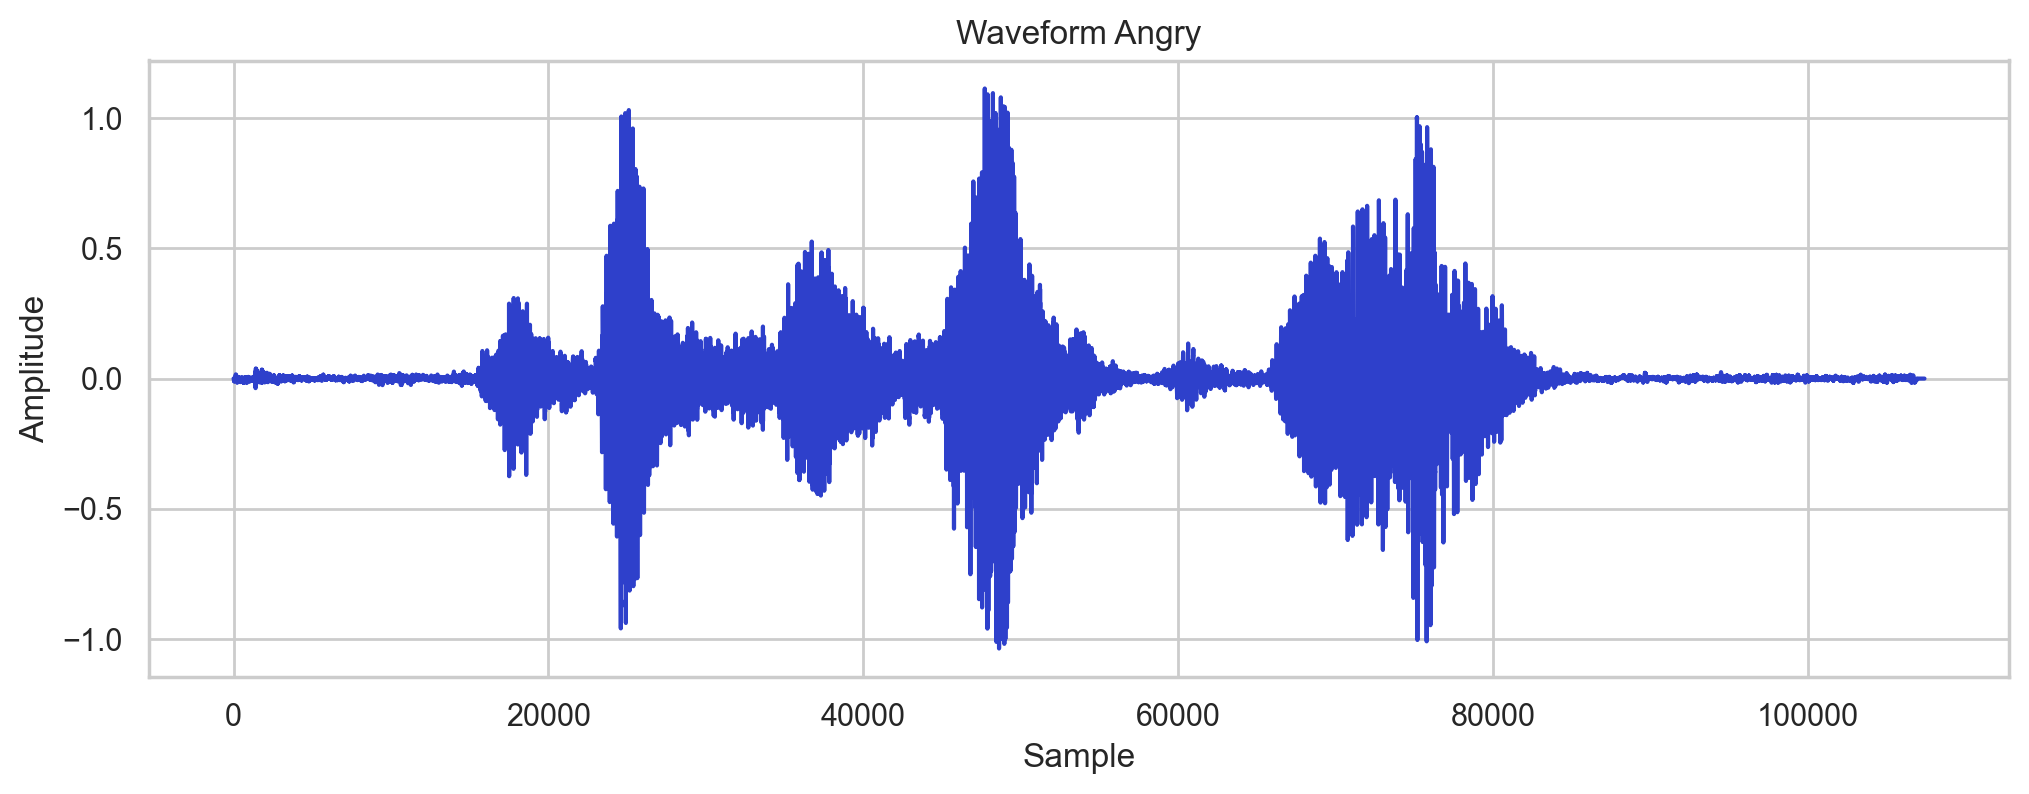

In [38]:
angry_sp = Sum_df_rep[Sum_df_rep['Emotions'] == 'Anger']['Path']
angry_arr = Sum_df_rep[Sum_df_rep['Emotions'] == 'Anger']['Arrays']

plt.figure(figsize=(12, 4), dpi=200)
plt.plot(angry_arr.iloc[0], color='#2E40CB')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Waveform Angry')
plt.show()

Audio(angry_sp.iloc[0])

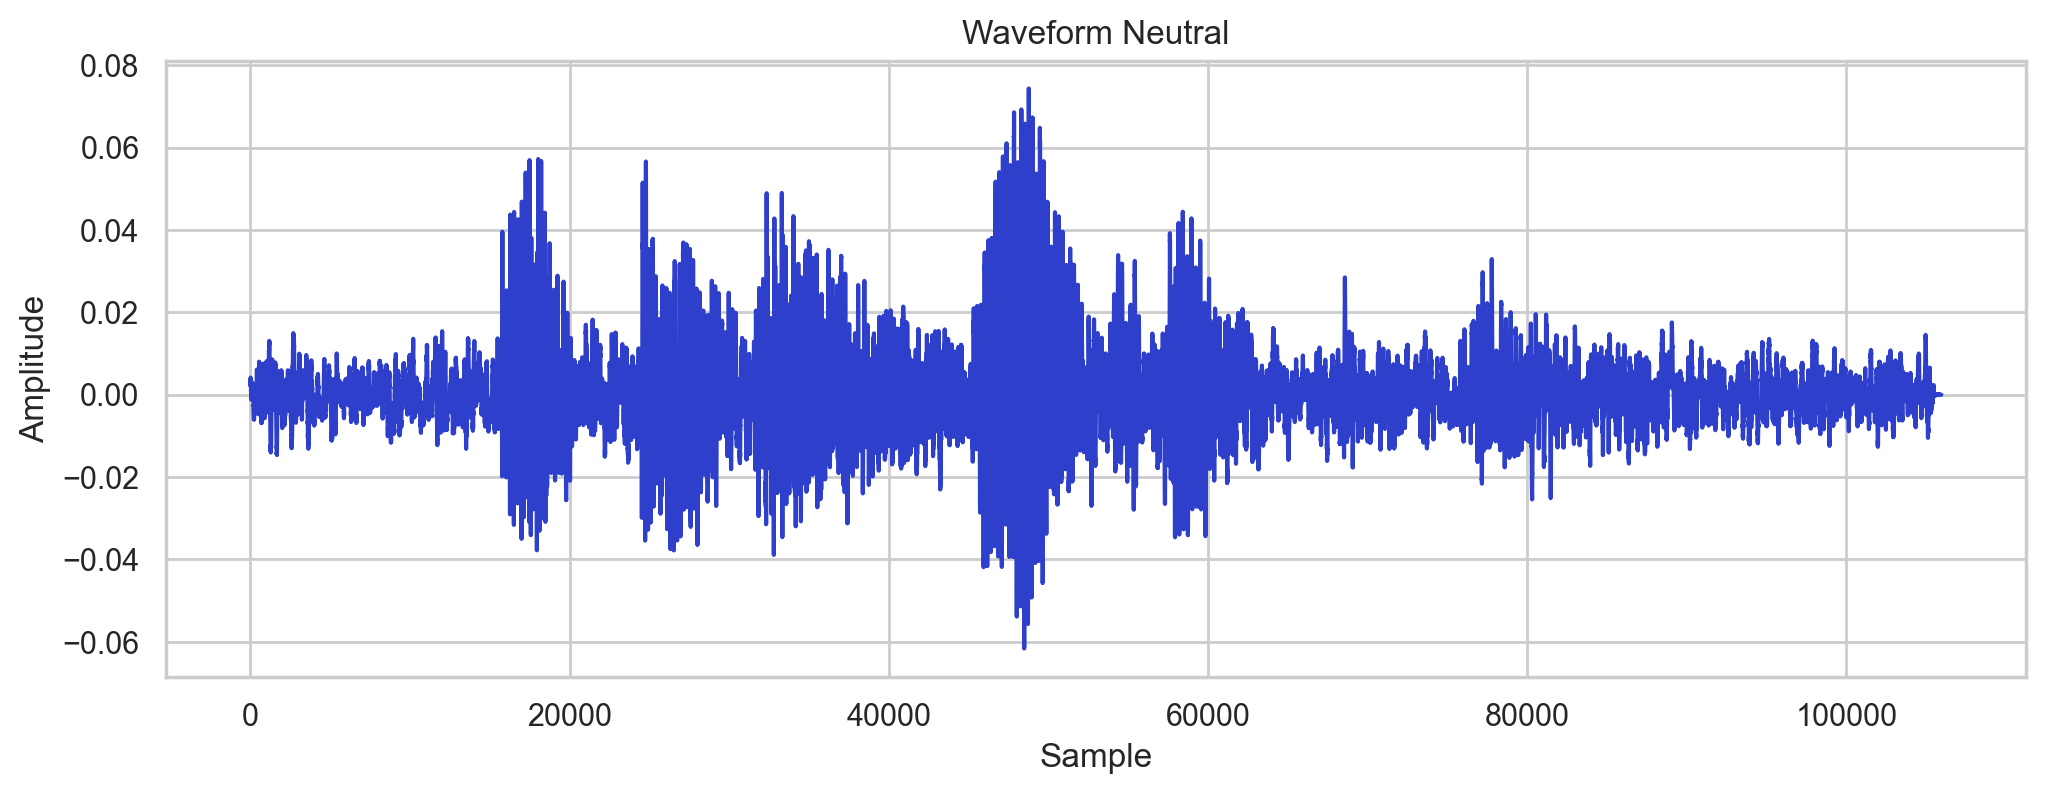

In [39]:
neutral_sp = Sum_df_rep[Sum_df_rep['Emotions'] == 'Neutral']['Path']
neutral_arr = Sum_df_rep[Sum_df_rep['Emotions'] == 'Neutral']['Arrays']

plt.figure(figsize=(12, 4), dpi=200)
plt.plot(neutral_arr.iloc[0], color='#2E40CB')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Waveform Neutral')
plt.show()

Audio(neutral_sp.iloc[0])

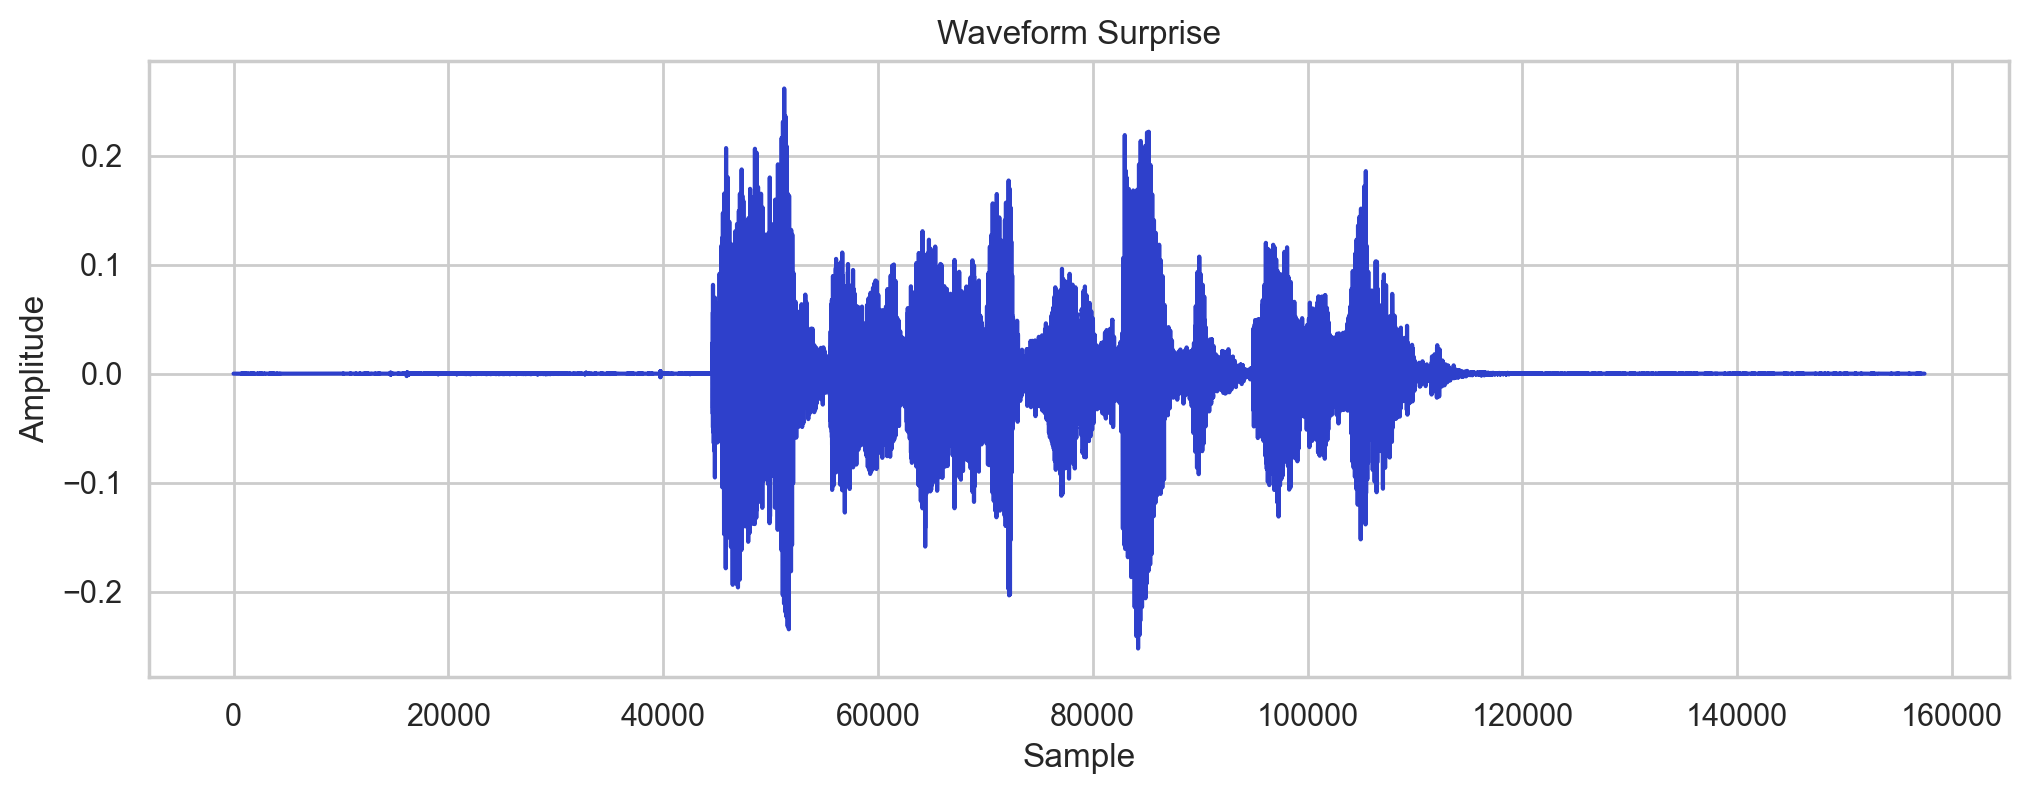

In [40]:
surprise_sp = Sum_df_rep[Sum_df_rep['Emotions'] == 'Surprise']['Path']
surprise_arr = Sum_df_rep[Sum_df_rep['Emotions'] == 'Surprise']['Arrays']

plt.figure(figsize=(12, 4), dpi=200)
plt.plot(surprise_arr.iloc[0], color='#2E40CB')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Waveform Surprise')
plt.show()

Audio(surprise_sp.iloc[0])

In [41]:
sample_duration = 1/sr
print(sample_duration)

2.2675736961451248e-05


In [42]:
#duration of the audio signals in seconds
duration = sample_duration * len(audio_arrays)
print(f"Duration of signal is: {duration:.2f} seconds")

Duration of signal is: 0.28 seconds


In [43]:
Frame_size = 1024
#HOP =  Current frame how many samples shift to the right for calculating the next frame
Hop_lenght = 512 

#calculate the amplitude envelope

def amplitude_env (signal, frame_size, hop_length):
    amplitude_envelope = []
    
    #calculate AE (Amp Env) for each frame
    for i in range (0, len(signal), hop_length):
        current_frame_amplitude_env = max(signal[i:i+frame_size])
        amplitude_envelope.append(current_frame_amplitude_env)
        
    return np.array(amplitude_envelope)


def fancy_amplitude_env (signal, frame_size, hop_length):
    
    return np.array([max(signal[i:i+frame_size]) for i in range(0, signal.size, hop_length)])

In [44]:
# Samples

Sp_fear = fear_arr.iloc[0]
Sp_disgust= disgust_arr.iloc[0]
Sp_happy= happy_arr.iloc[0]
Sp_sad = sad_arr.iloc[0]
Sp_neutral = neutral_arr.iloc[0]
Sp_angry = angry_arr.iloc[0]
Sp_surprise = surprise_arr.iloc[0]

In [45]:
AE_fear = amplitude_env(Sp_fear, Frame_size, Hop_lenght)
AE_disgust = amplitude_env(Sp_disgust, Frame_size, Hop_lenght)
AE_happy = amplitude_env(Sp_happy, Frame_size, Hop_lenght)
AE_sad = amplitude_env(Sp_sad, Frame_size, Hop_lenght)
AE_neutral = amplitude_env(Sp_neutral, Frame_size, Hop_lenght)
AE_angry = amplitude_env(Sp_angry, Frame_size, Hop_lenght)
AE_surprise = amplitude_env(Sp_surprise, Frame_size, Hop_lenght)

print(len(AE_fear), len(AE_disgust), len(AE_angry), len(AE_happy), len(AE_neutral),
     len(AE_surprise), len(AE_sad))


317 248 210 276 207 308 210


In [46]:
fancy_AE_fear = fancy_amplitude_env(Sp_fear, Frame_size, Hop_lenght)
fancy_AE_disgust = fancy_amplitude_env(Sp_disgust, Frame_size, Hop_lenght)
fancy_AE_happy = fancy_amplitude_env(Sp_happy, Frame_size, Hop_lenght)
fancy_AE_sad = fancy_amplitude_env(Sp_sad, Frame_size, Hop_lenght)
fancy_AE_neutral = fancy_amplitude_env(Sp_neutral, Frame_size, Hop_lenght)
fancy_AE_angry = fancy_amplitude_env(Sp_angry, Frame_size, Hop_lenght)
fancy_AE_surprise = fancy_amplitude_env(Sp_surprise, Frame_size, Hop_lenght)

print(len(fancy_AE_fear), len(fancy_AE_disgust), len(fancy_AE_angry),
      len(fancy_AE_happy), len(fancy_AE_neutral),
     len(fancy_AE_surprise), len(fancy_AE_sad))

317 248 210 276 207 308 210


In [47]:
(AE_fear == fancy_AE_fear).all()

True

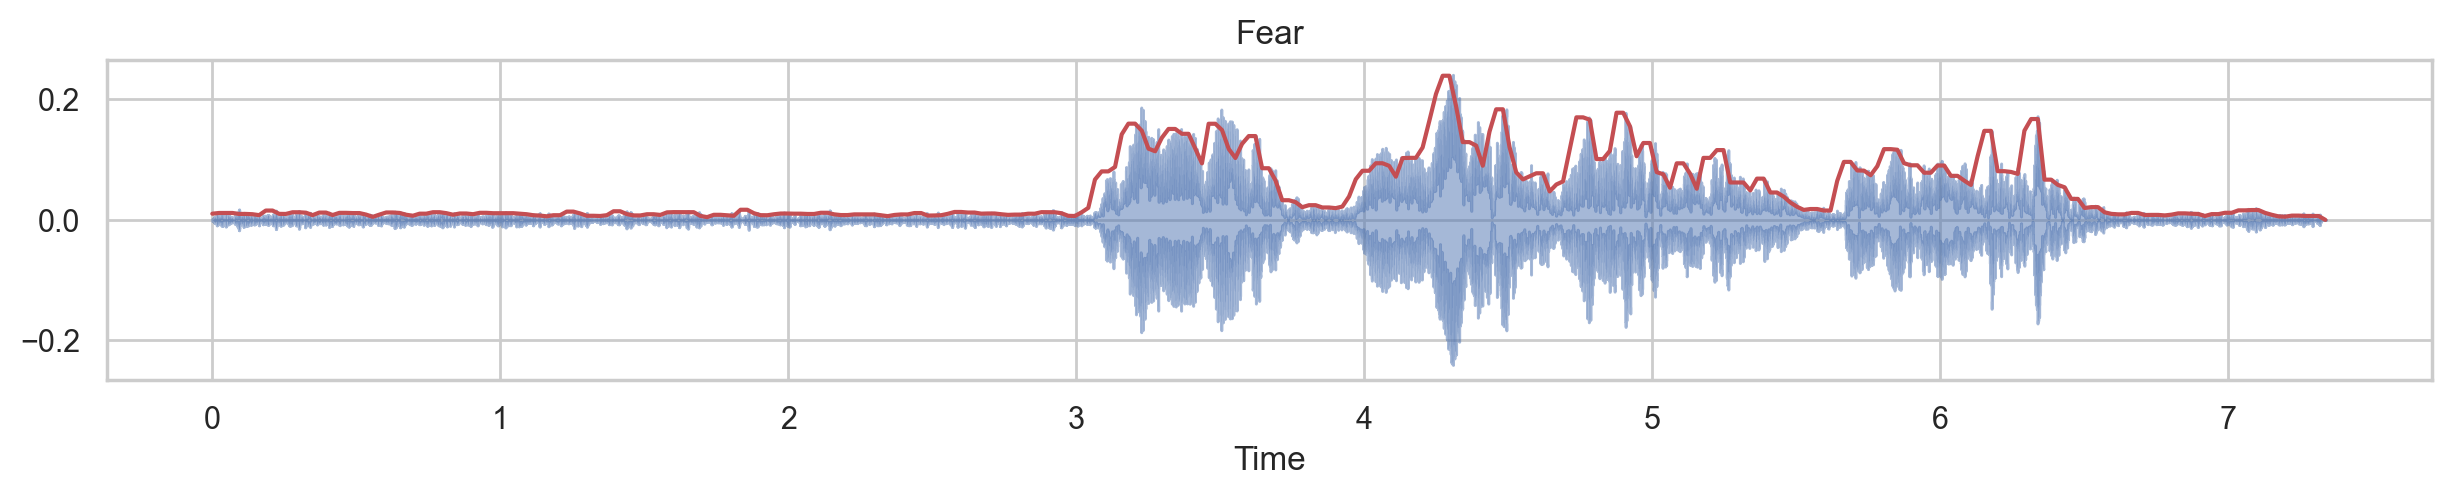

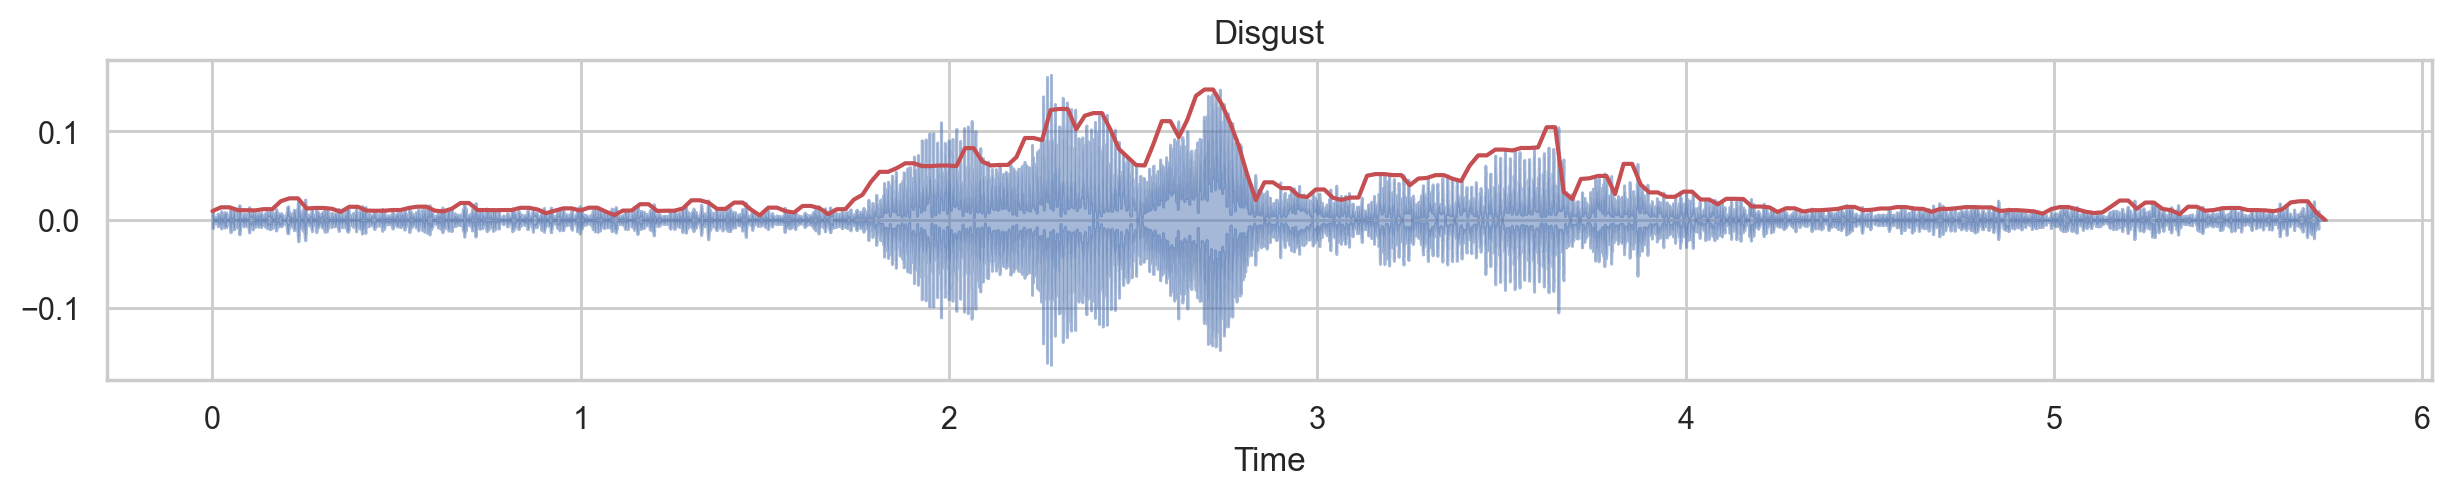

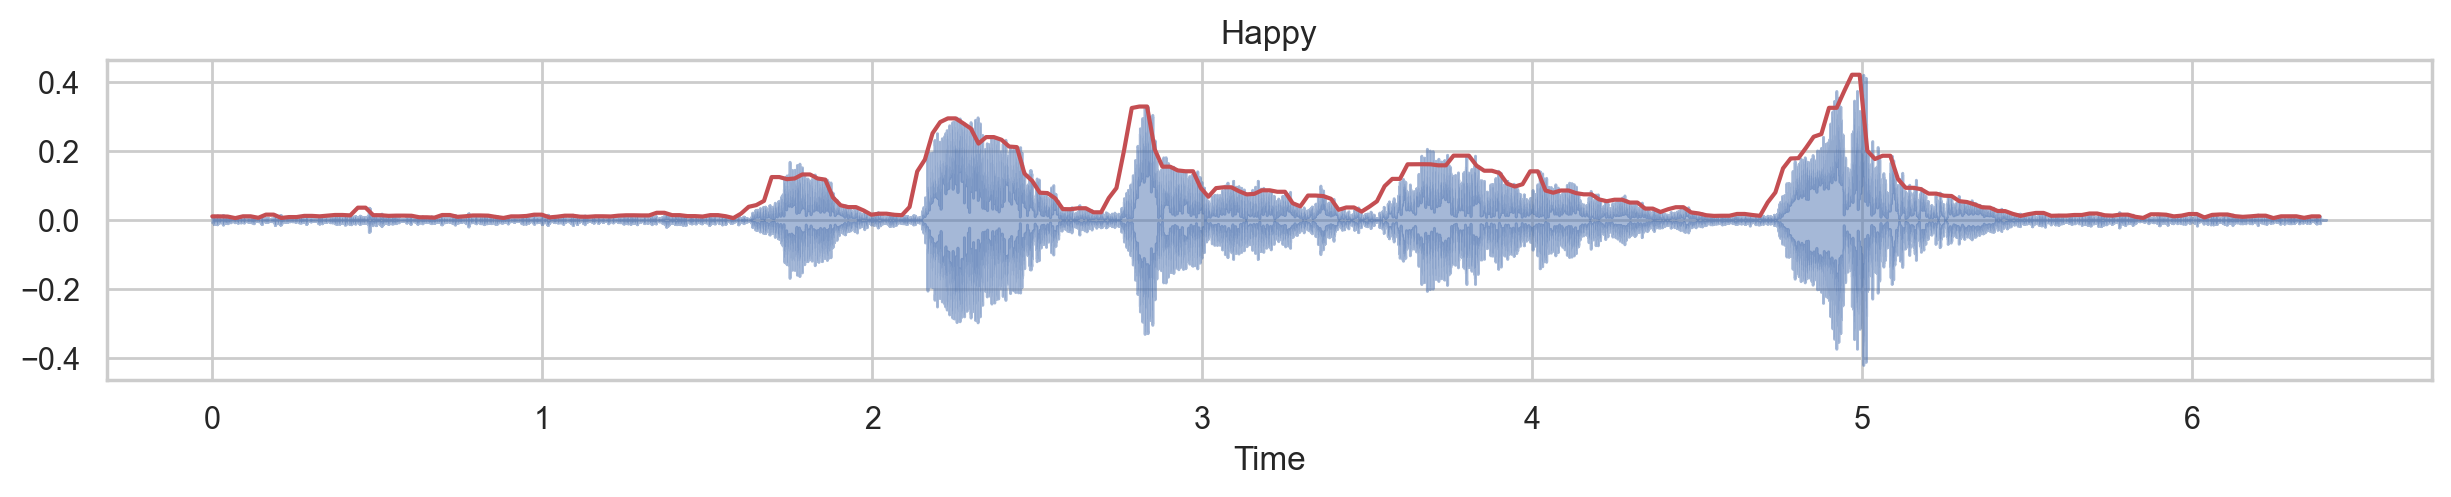

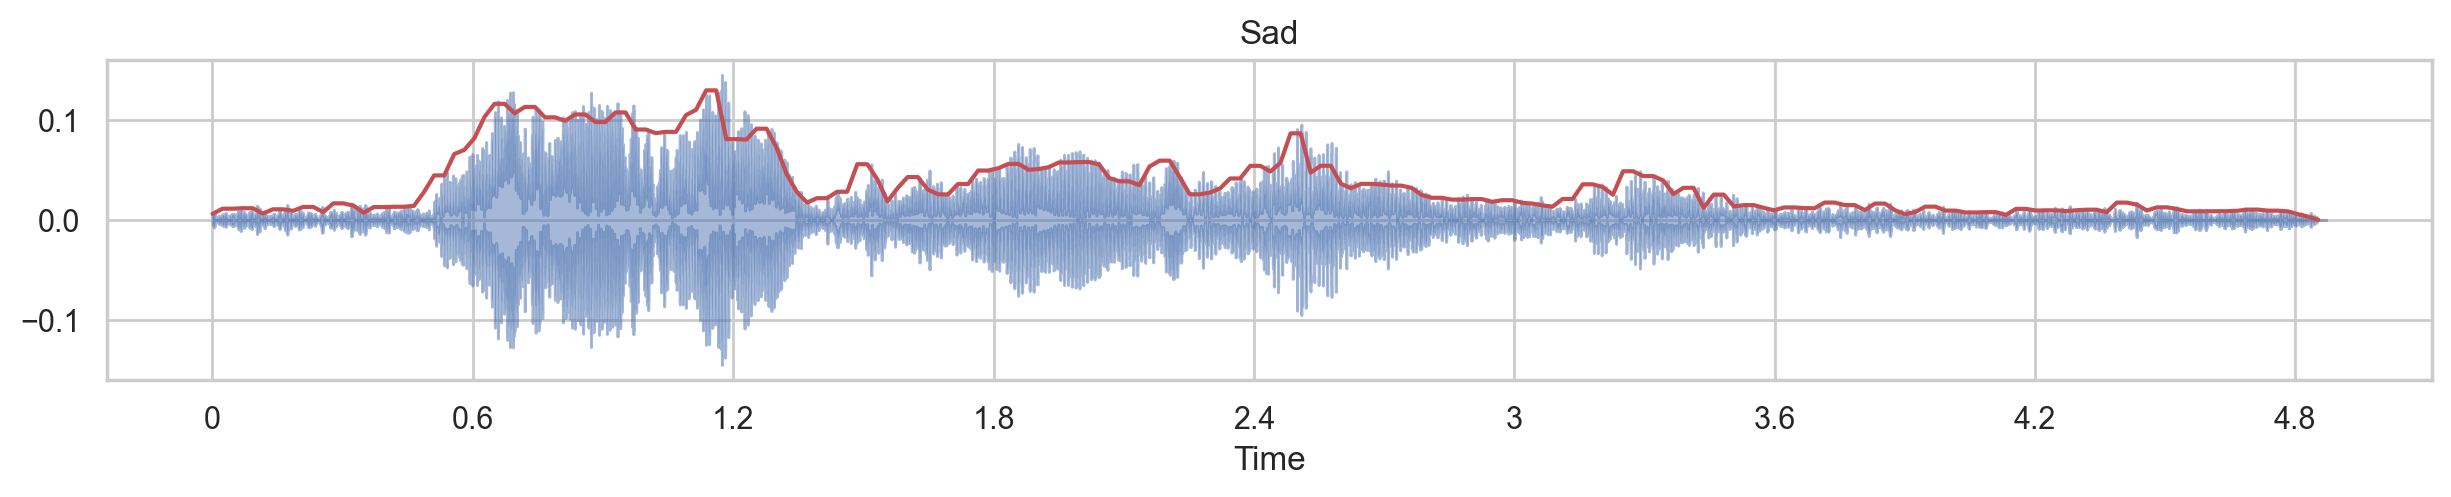

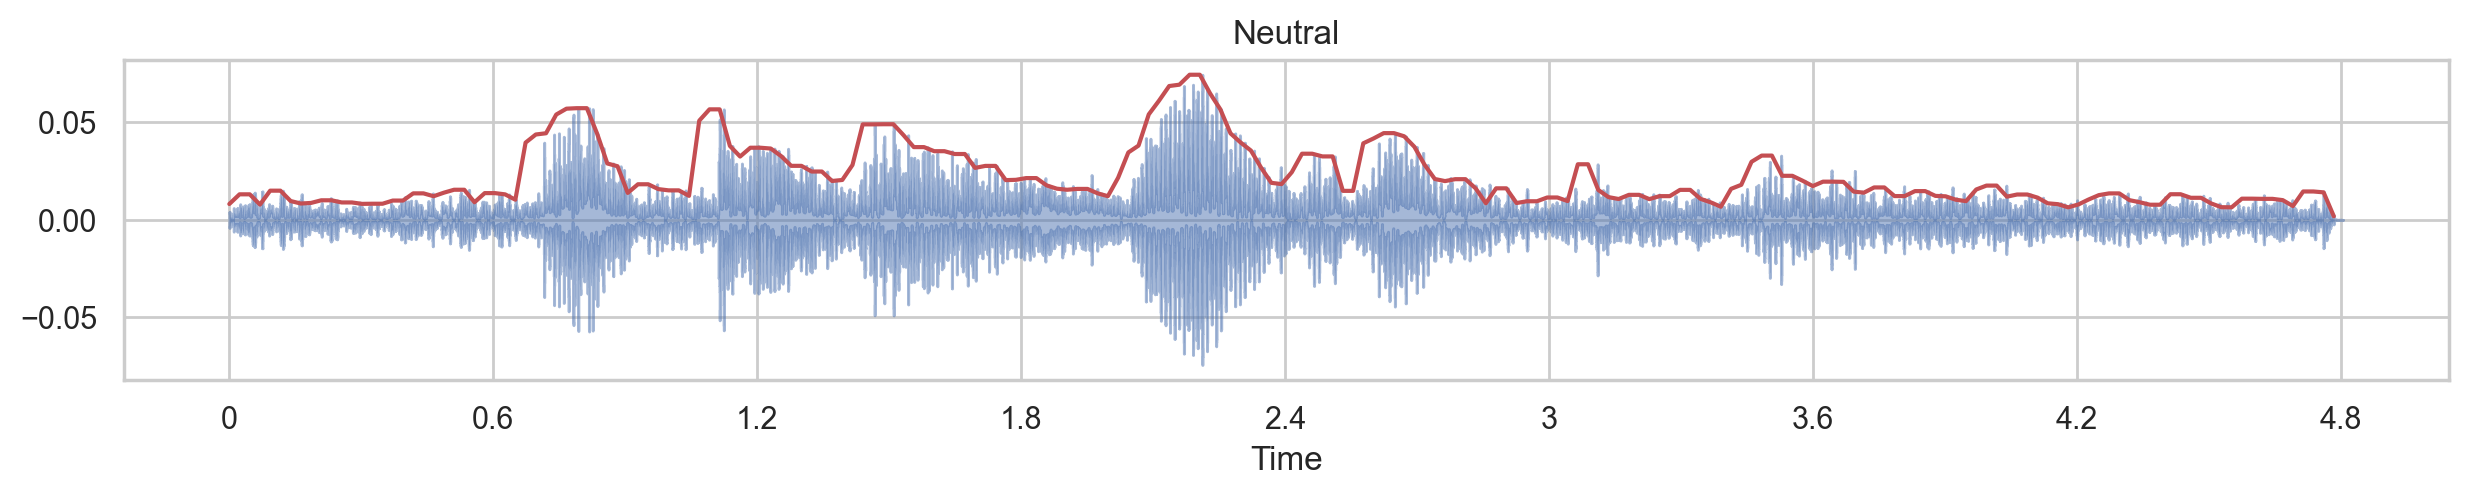

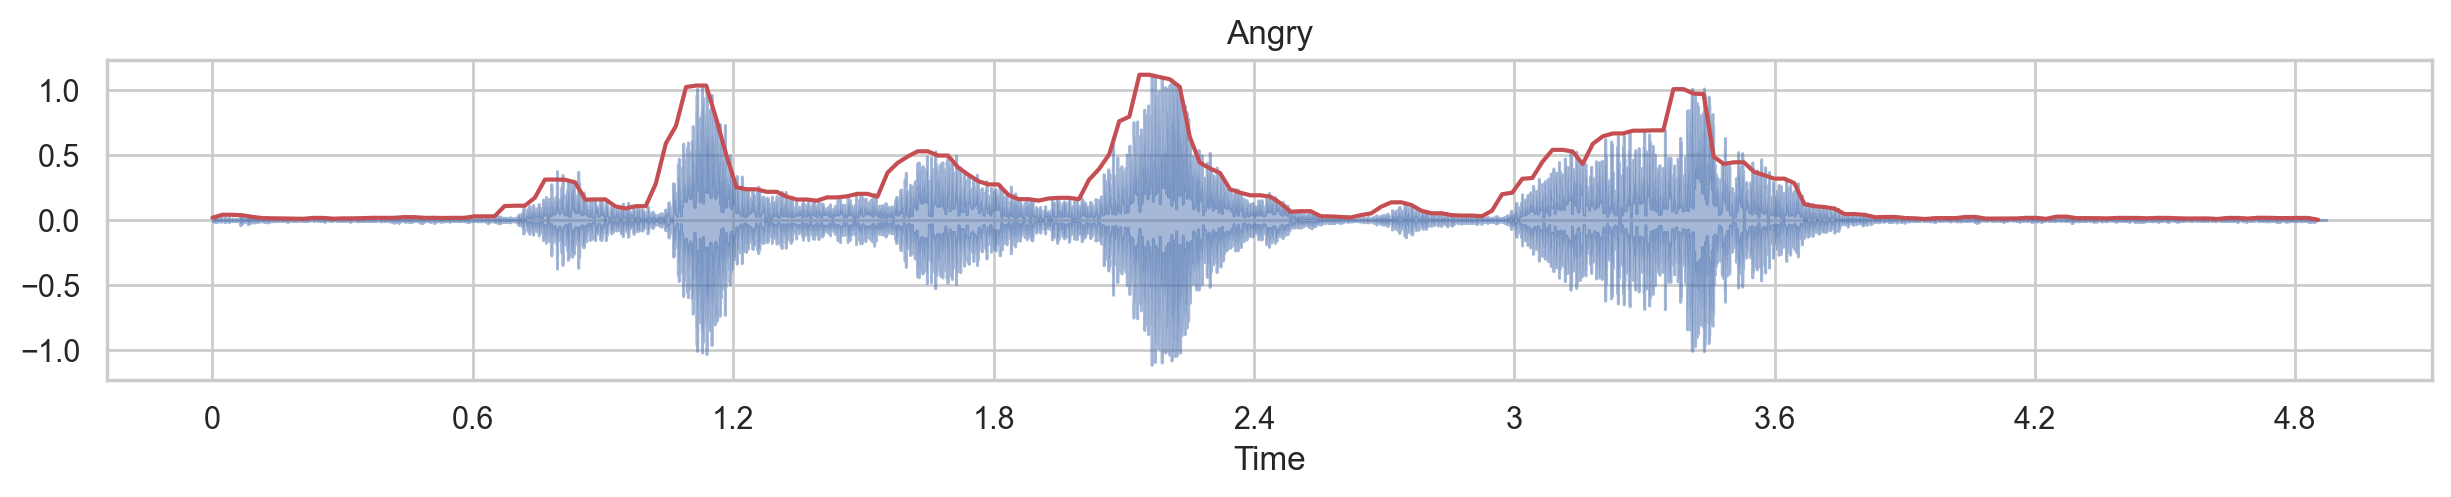

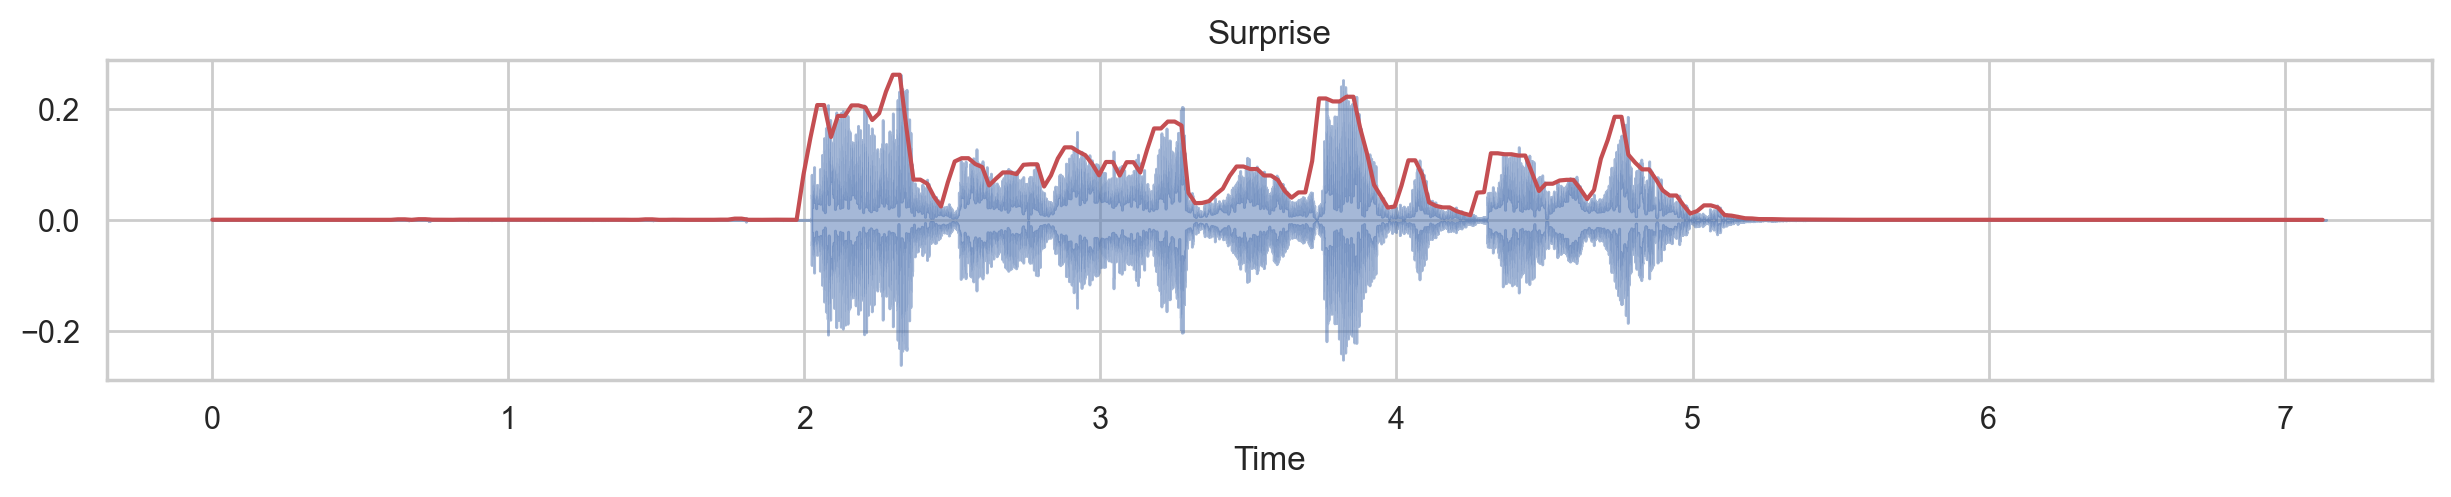

In [48]:
#Visualize amplitude envelope for all the audio files (Samples of each)

frames_fear = range(0, AE_fear.size)
frames_disgust = range(0, AE_disgust.size)
frames_happy = range(0, AE_happy.size)
frames_sad = range(0, AE_sad.size)
frames_neutral = range(0, AE_neutral.size)
frames_angry = range(0, AE_angry.size)
frames_surprise = range(0, AE_surprise.size)

t1 = librosa.frames_to_time(frames_fear, hop_length = Hop_lenght)
t2 = librosa.frames_to_time(frames_disgust, hop_length = Hop_lenght)
t3 = librosa.frames_to_time(frames_happy, hop_length = Hop_lenght)
t4 = librosa.frames_to_time(frames_sad, hop_length = Hop_lenght)
t5 = librosa.frames_to_time(frames_neutral, hop_length = Hop_lenght)
t6 = librosa.frames_to_time(frames_angry, hop_length = Hop_lenght)
t7 = librosa.frames_to_time(frames_surprise, hop_length = Hop_lenght)


plt.figure(figsize=(15,17), dpi=200)
plt.subplot(7,1,1)
librosa.display.waveshow(Sp_fear, alpha = 0.5)
plt.plot(t1, AE_fear, color = "r")
plt.title("Fear")
plt.show()

plt.figure(figsize=(15,17), dpi=200)
plt.subplot(7,1,2)
librosa.display.waveshow(Sp_disgust, alpha = 0.5)
plt.plot(t2, AE_disgust, color = "r")
plt.title("Disgust")
plt.show()

plt.figure(figsize=(15,17), dpi=200)
plt.subplot(7,1,3)
librosa.display.waveshow(Sp_happy, alpha = 0.5)
plt.plot(t3, AE_happy, color = "r")
plt.title("Happy")
plt.show()

plt.figure(figsize=(15,17), dpi=200)
plt.subplot(7,1,4)
librosa.display.waveshow(Sp_sad, alpha = 0.5)
plt.plot(t4, AE_sad, color = "r")
plt.title("Sad")
plt.show()


plt.figure(figsize=(15,17), dpi=200)
plt.subplot(7,1,5)
librosa.display.waveshow(Sp_neutral, alpha = 0.5)
plt.plot(t5, AE_neutral, color = "r")
plt.title("Neutral")
plt.show()


plt.figure(figsize=(15,17), dpi=200)
plt.subplot(7,1,6)
librosa.display.waveshow(Sp_angry, alpha = 0.5)
plt.plot(t6, AE_angry, color = "r")
plt.title("Angry")
plt.show()


plt.figure(figsize=(15,17), dpi=200)
plt.subplot(7,1,7)
librosa.display.waveshow(Sp_surprise, alpha = 0.5)
plt.plot(t7, AE_surprise, color = "r")
plt.title("Surprise")
plt.show()

In [49]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=0.8)

path = np.array(Sum_df_rep.Path)[1]
data, sample_rate = librosa.load(path)

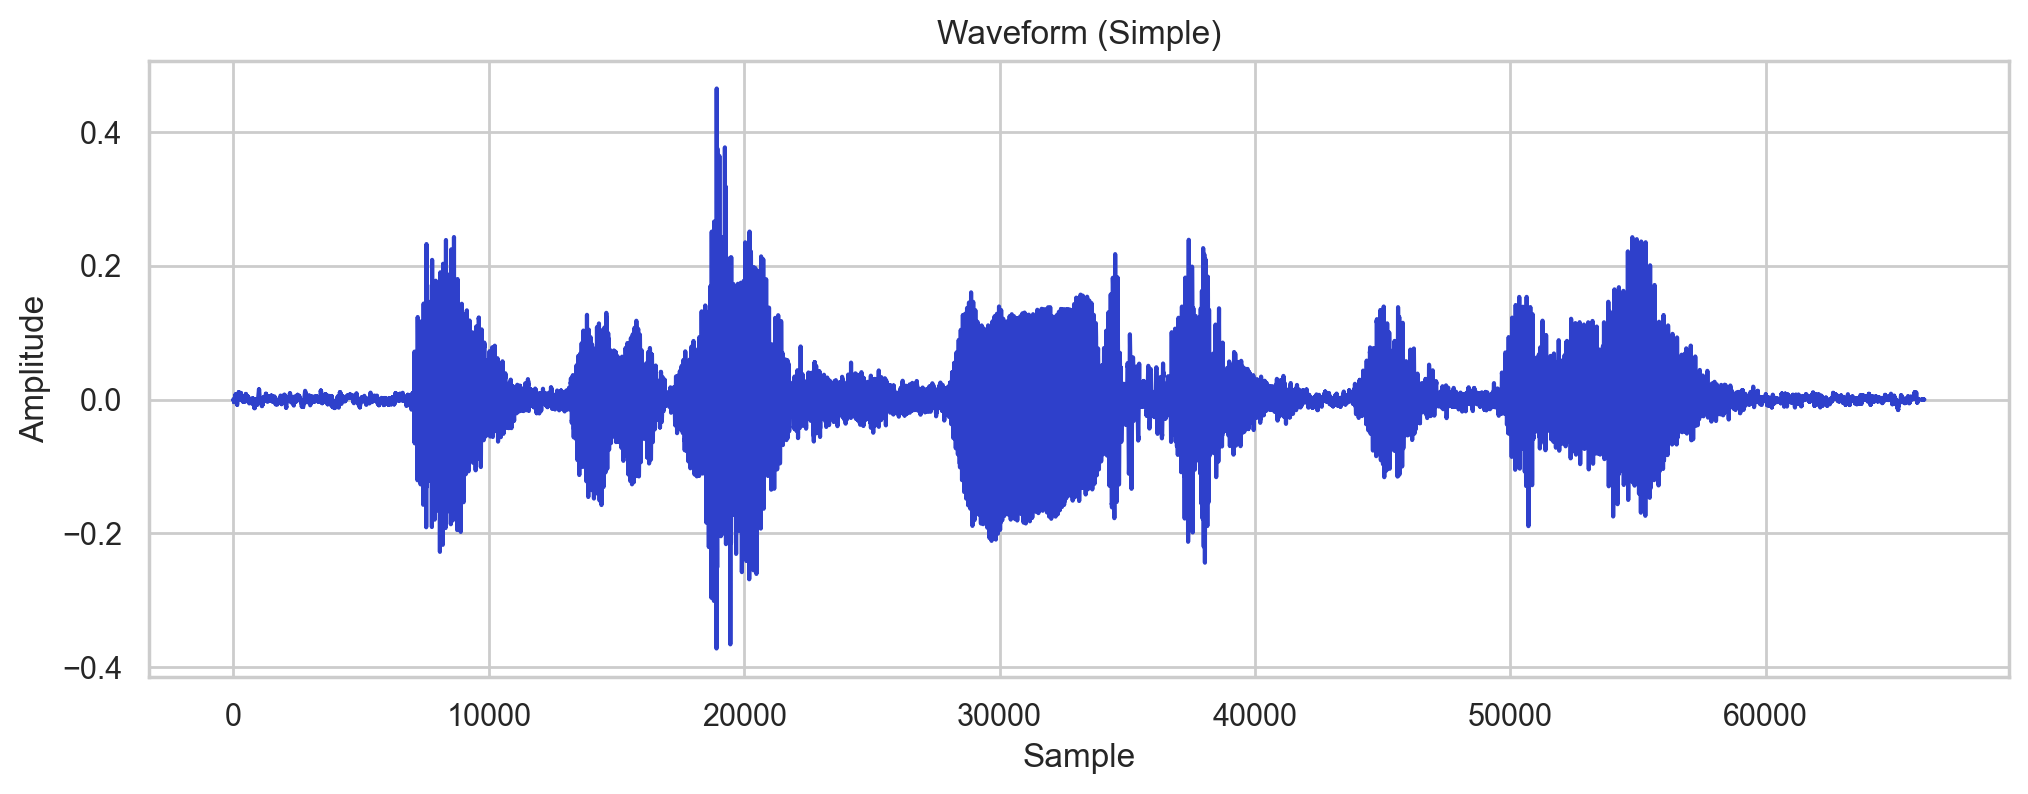

In [50]:
Simple_data = data
plt.figure(figsize=(12, 4), dpi=200)
plt.plot(Simple_data ,color='#2E40CB')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Waveform (Simple)')
plt.show()

Audio(Simple_data, rate=sample_rate)

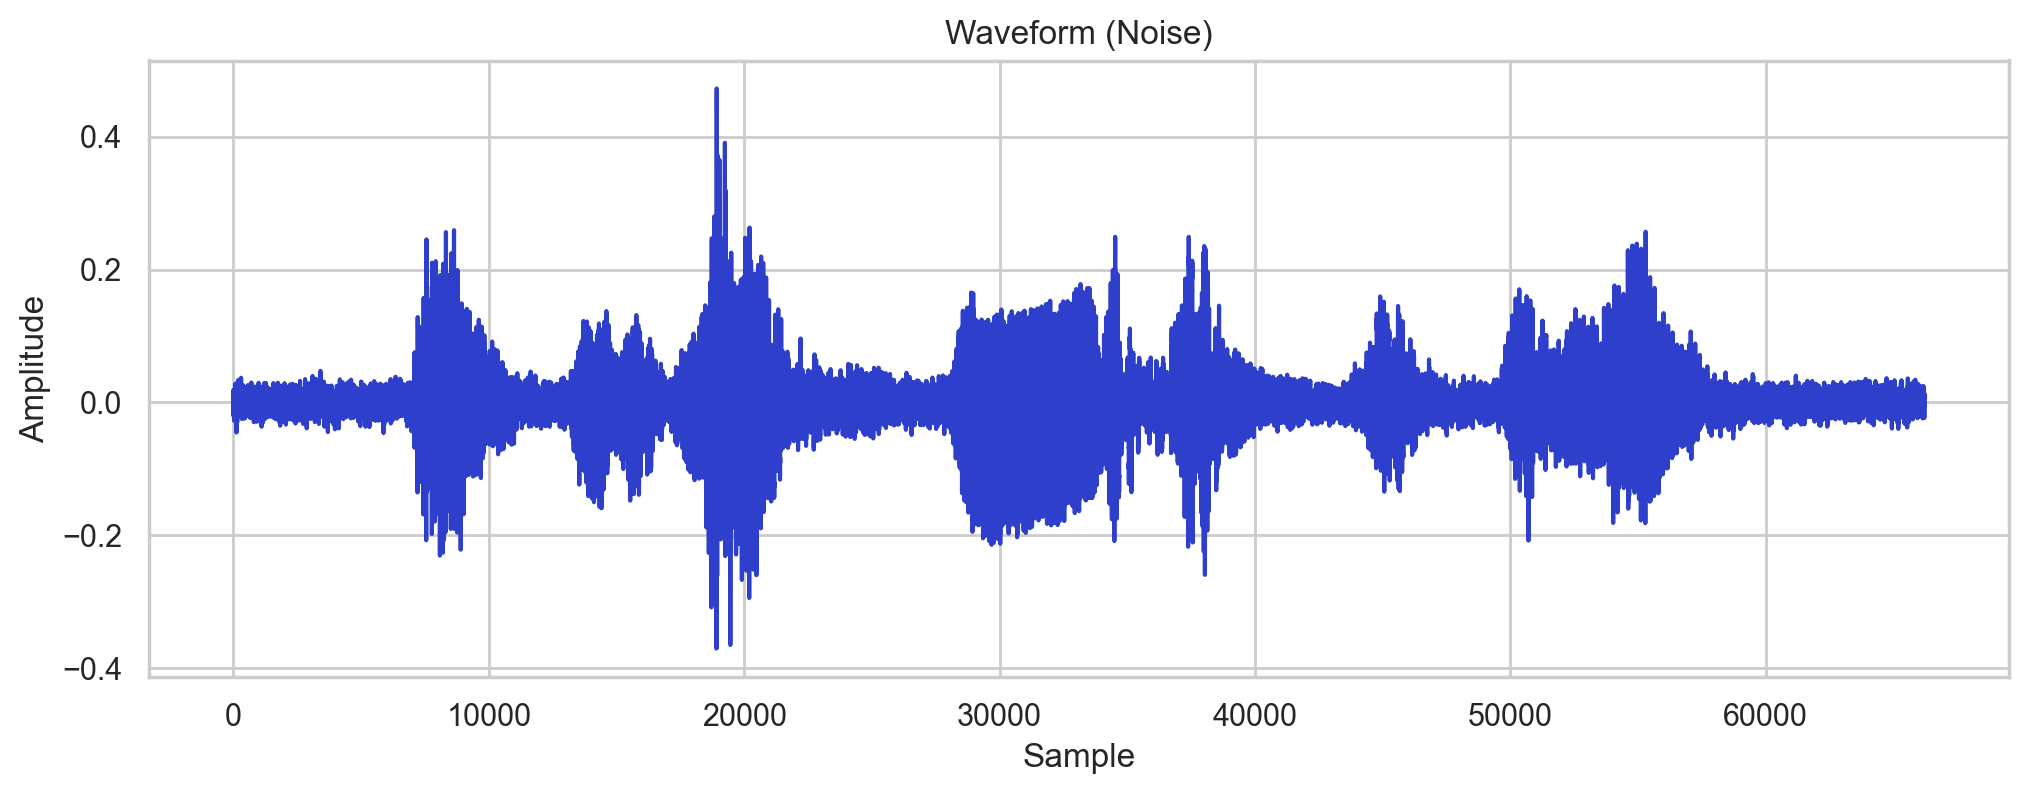

In [51]:
Noise_data = noise(data)
plt.figure(figsize=(12, 4), dpi=200)
plt.plot(Noise_data ,color='#2E40CB')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Waveform (Noise)')
plt.show()

Audio(Noise_data, rate=sample_rate)

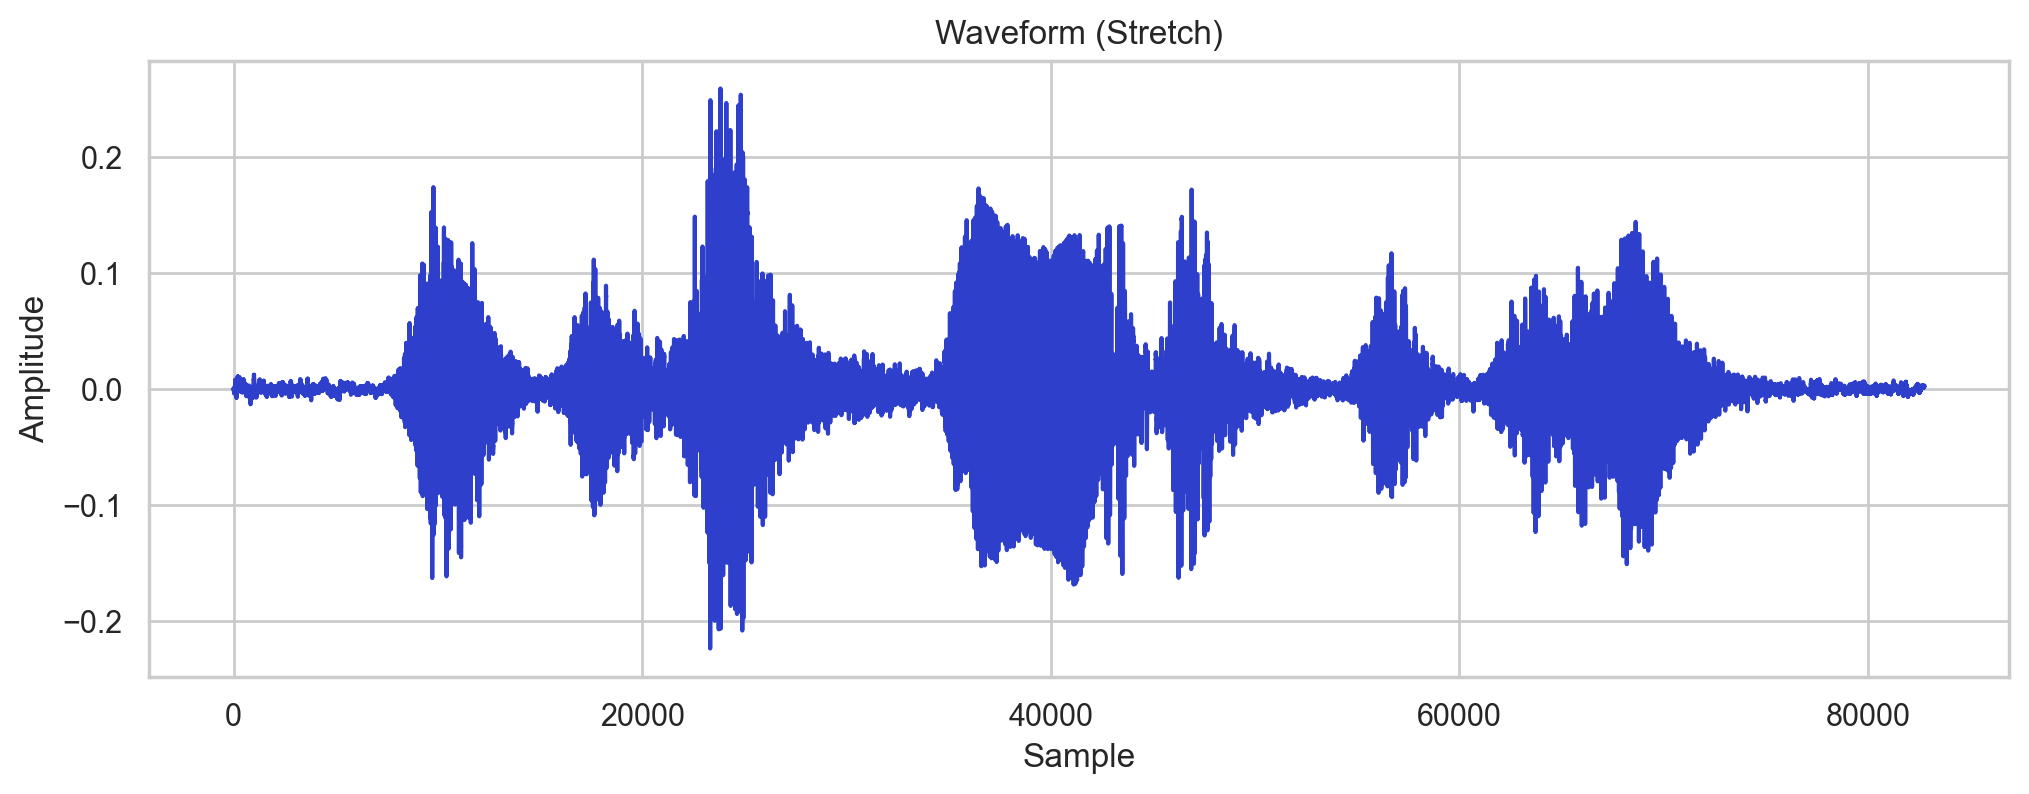

In [52]:
Stretch_data = stretch(data)
plt.figure(figsize=(12, 4), dpi=200)
plt.plot(Stretch_data ,color='#2E40CB')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Waveform (Stretch)')
plt.show()

Audio(Stretch_data, rate=sample_rate)

# Podzielenie na zbiory uczace i testowe

In [53]:
SEED = 42

In [54]:
Crema_df = Crema_df[Crema_df["Emotions"].isin(classes)]
Ravdess_df = Ravdess_df[Ravdess_df["Emotions"].isin(classes)]
Savee_df = Savee_df[Savee_df["Emotions"].isin(classes)]
Tess_df = Tess_df[Tess_df["Emotions"].isin(classes)]

In [55]:
train_crema, test_crema = train_test_split(Crema_df, test_size=0.2, random_state=SEED)
train_ravdess, test_ravdess = train_test_split(Ravdess_df, test_size=0.2, random_state=SEED)
train_savee, test_savee = train_test_split(Savee_df, test_size=0.2, random_state=SEED)
train_tess, test_tess = train_test_split(Tess_df, test_size=0.2, random_state=SEED)

In [56]:
print(len(train_crema)+len(train_ravdess)+len(train_savee)+len(train_tess), len(test_crema)+len(test_ravdess)+len(test_savee)+len(test_tess))

9053 2265


In [57]:
train_sum = pd.concat([train_crema, train_ravdess, train_savee, train_tess], ignore_index=True)
test_sum = pd.concat([test_crema, test_ravdess, test_savee, test_tess], ignore_index=True)

In [58]:
print(len(train_sum), len(test_sum))

9053 2265


In [59]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration = 3, offset = 0.5)
    mfcc = np.mean(librosa.feature.mfcc(y = y, sr = sr, n_mfcc = 40).T, axis = 0)
    return mfcc

In [60]:
%%time
X_mfcc_train = train_sum['Path'].apply(lambda x: extract_mfcc(x))
X_mfcc_test = test_sum['Path'].apply(lambda x: extract_mfcc(x))

CPU times: user 6min 27s, sys: 7.32 s, total: 6min 34s
Wall time: 41.1 s


In [61]:
X_train = [x for x in X_mfcc_train]
X_test = [x for x in X_mfcc_test]

X_train = np.array(X_train)
X_test = np.array(X_test)
X_train.shape

(9053, 40)

In [62]:
## input split
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)
X_train.shape

(9053, 40, 1)

In [63]:
enc = OneHotEncoder()
y_train = enc.fit_transform(train_sum[['Emotions']])
y_test = enc.fit_transform(test_sum[['Emotions']])

In [64]:
y_train = y_train.toarray()
y_test = y_test.toarray()

In [65]:
model = Sequential([
    Bidirectional(LSTM(256, return_sequences=False), input_shape=(40, 1)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(6, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

2024-11-11 16:40:40.257272: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-11-11 16:40:40.257316: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-11-11 16:40:40.257336: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-11-11 16:40:40.257365: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-11 16:40:40.257384: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 512)            │       528,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 594,822 (2.27 MB)

 Trainable params: 594,822 (2.27 MB)

 Non-trainable params: 0 (0.00 B)

In [66]:
filepath = f'../models/{model_name}_{optimizer}_{idx}.keras'

In [67]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler_callback = LearningRateScheduler(scheduler)
early_stopping = EarlyStopping(patience=15, verbose=1)
mcp_save = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', mode='min')

history = model.fit(X_train, y_train, validation_split=0.2, epochs=500, batch_size=64, callbacks=[early_stopping, mcp_save])

Epoch 1/500


2024-11-11 16:40:41.100411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.2613 - loss: 1.7097 - val_accuracy: 0.3468 - val_loss: 1.3665
Epoch 2/500
114/114 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - accuracy: 0.3488 - loss: 1.5511 - val_accuracy: 0.4506 - val_loss: 1.2683
Epoch 3/500
114/114 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.3413 - loss: 1.5198 - val_accuracy: 0.4136 - val_loss: 1.3391
Epoch 4/500
114/114 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.3763 - loss: 1.4915 - val_accuracy: 0.5649 - val_loss: 1.1764
Epoch 5/500
114/114 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.3821 - loss: 1.4702 - val_accuracy: 0.5975 - val_loss: 1.0653
Epoch 6/500
114/114 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.4158 - loss: 1.4323 - val_accuracy: 0.6505 - val_loss: 0.9611
Epoch 7/500
114/114 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.3983 - loss: 1.4305 - val_accuracy: 0.6372 - val_loss: 0.9389
Epoch 8/500
114/114 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.4121 - loss: 1.4254 - val_accurac

# Ewaluacja modeli

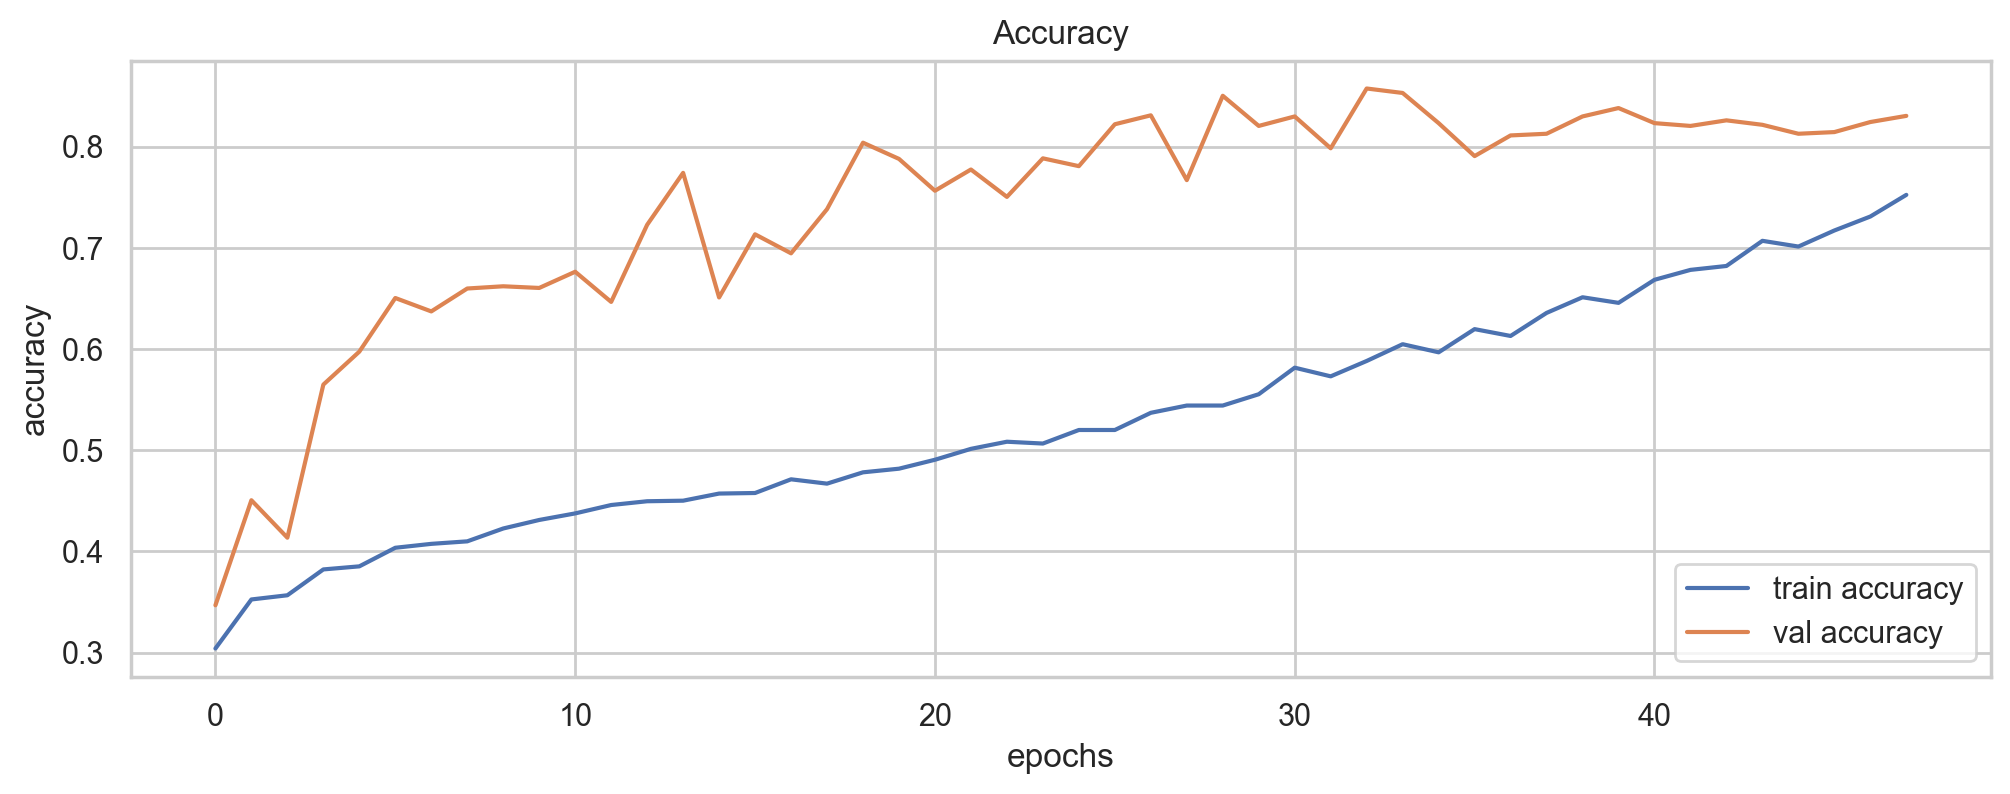

In [68]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(train_acc))

plt.figure(figsize=(12, 4), dpi=200)
plt.plot(epochs, train_acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Accuracy')
plt.legend(loc="lower right")
plt.show()

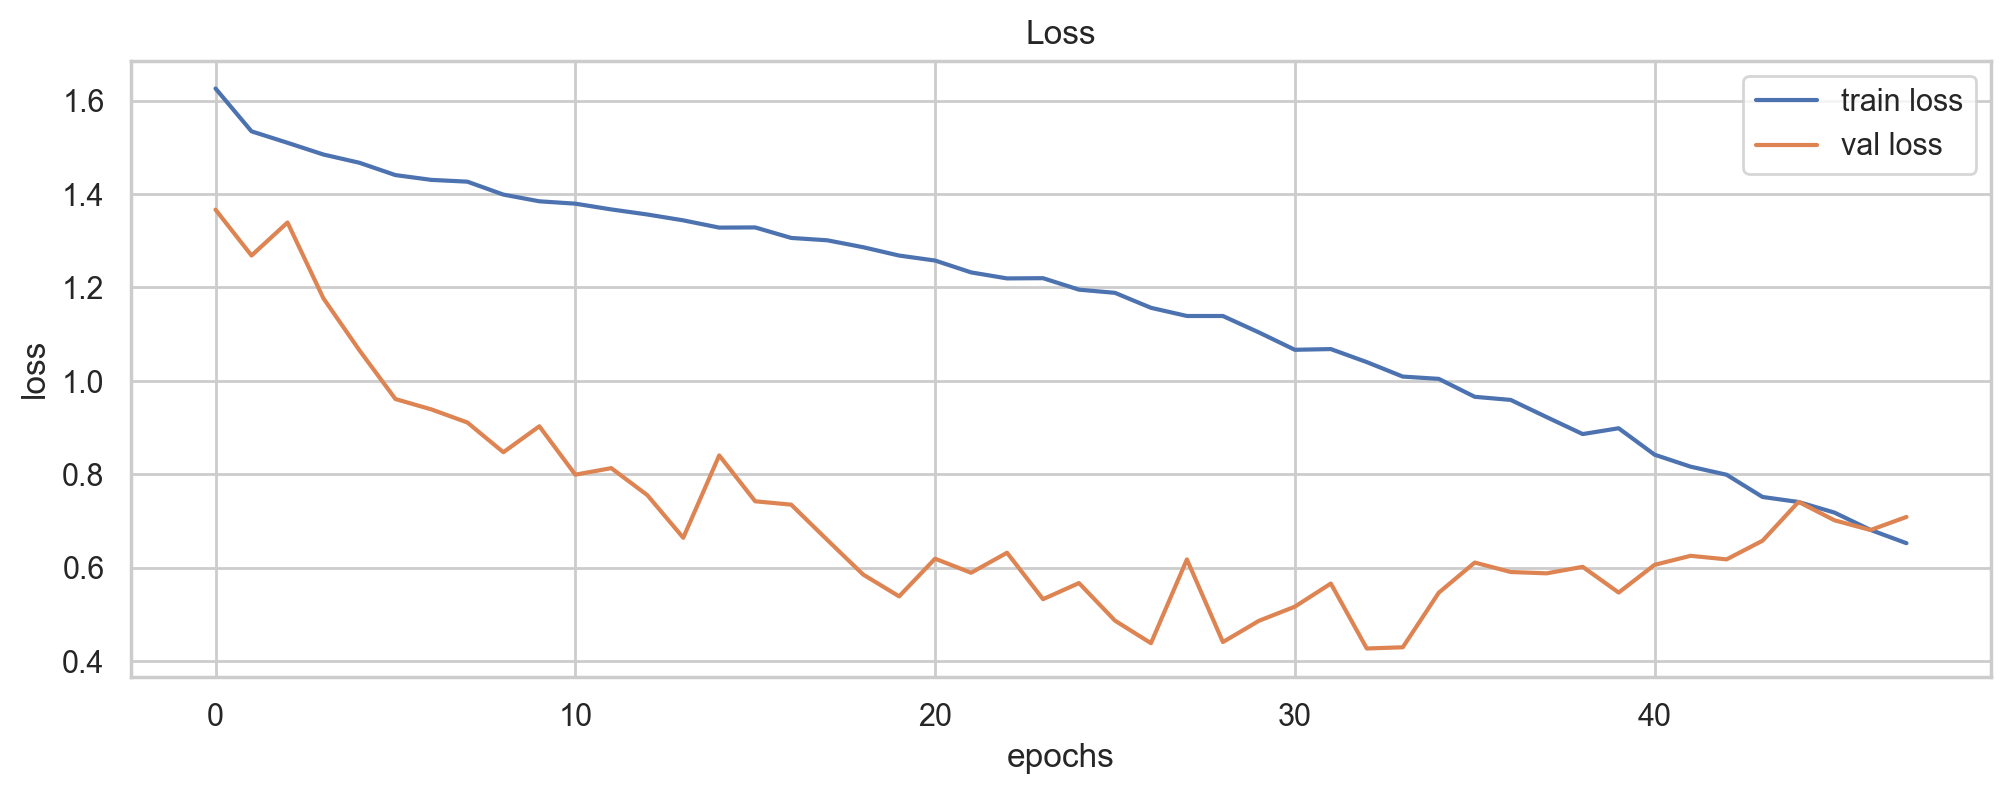

In [69]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4), dpi=200)
plt.plot(epochs, train_loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss')
plt.legend(loc="upper right")
plt.show()

In [70]:
def generate_confusion_matrix(model, test_data):
    fig, axes = plt.subplots(3, 2, figsize=(14, 18))
    
    axes = axes.flatten()

    accuracies = dict()
    
    for i, dataset in enumerate(test_data.keys()):
        X_test, y_test, class_names = test_data[dataset]
        predictions = model.predict(X_test)
        predicted_classes = np.argmax(predictions, axis=1)
    
        true_labels = y_test
        
        axes[i].grid(False)
        
        cm = confusion_matrix(true_labels, predicted_classes)
    
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(ax=axes[i], cmap=plt.cm.Blues, values_format='d')
        
        accuracies[dataset] = np.mean(predicted_classes == true_labels)
        
        axes[i].set_title(f"Confusion Matrix for {dataset}")
        axes[i].set_xlabel("Predicted Label")
        axes[i].set_ylabel("True Label")
        
    axes[-1].axis('off')
    plt.tight_layout()
    plt.savefig(f'../img/bidirectional_experiments/{model_name}_{optimizer}_{idx}.png')
    plt.show();

    for dataset, accuracy in accuracies.items():
        print(f"Accuracy for {dataset}: {accuracy*100:.2f}%")

    with open(f"../results/bidirectional_experiments/{model_name}_{optimizer}_{idx}.csv", "w", newline="") as f:
        w = csv.DictWriter(f, accuracies.keys())
        w.writeheader()
        w.writerow(accuracies)

In [71]:
def prepare_test_data(test_df):
    X_mfcc_test = test_df['Path'].apply(lambda x: extract_mfcc(x))
    X_test = [x for x in X_mfcc_test]
    X_test = np.expand_dims(X_test, -1)
    
    le = LabelEncoder()
    y_test = le.fit_transform(test_df[['Emotions']])
    classes = le.classes_

    return (X_test, y_test, classes)

In [72]:
test_data = {
    "Sum": prepare_test_data(test_sum),
    "Crema": prepare_test_data(test_crema),
    "Ravdess": prepare_test_data(test_ravdess),
    "Savee": prepare_test_data(test_crema),
    "Tess": prepare_test_data(test_tess),
}

In [73]:
model.load_weights(filepath)

71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


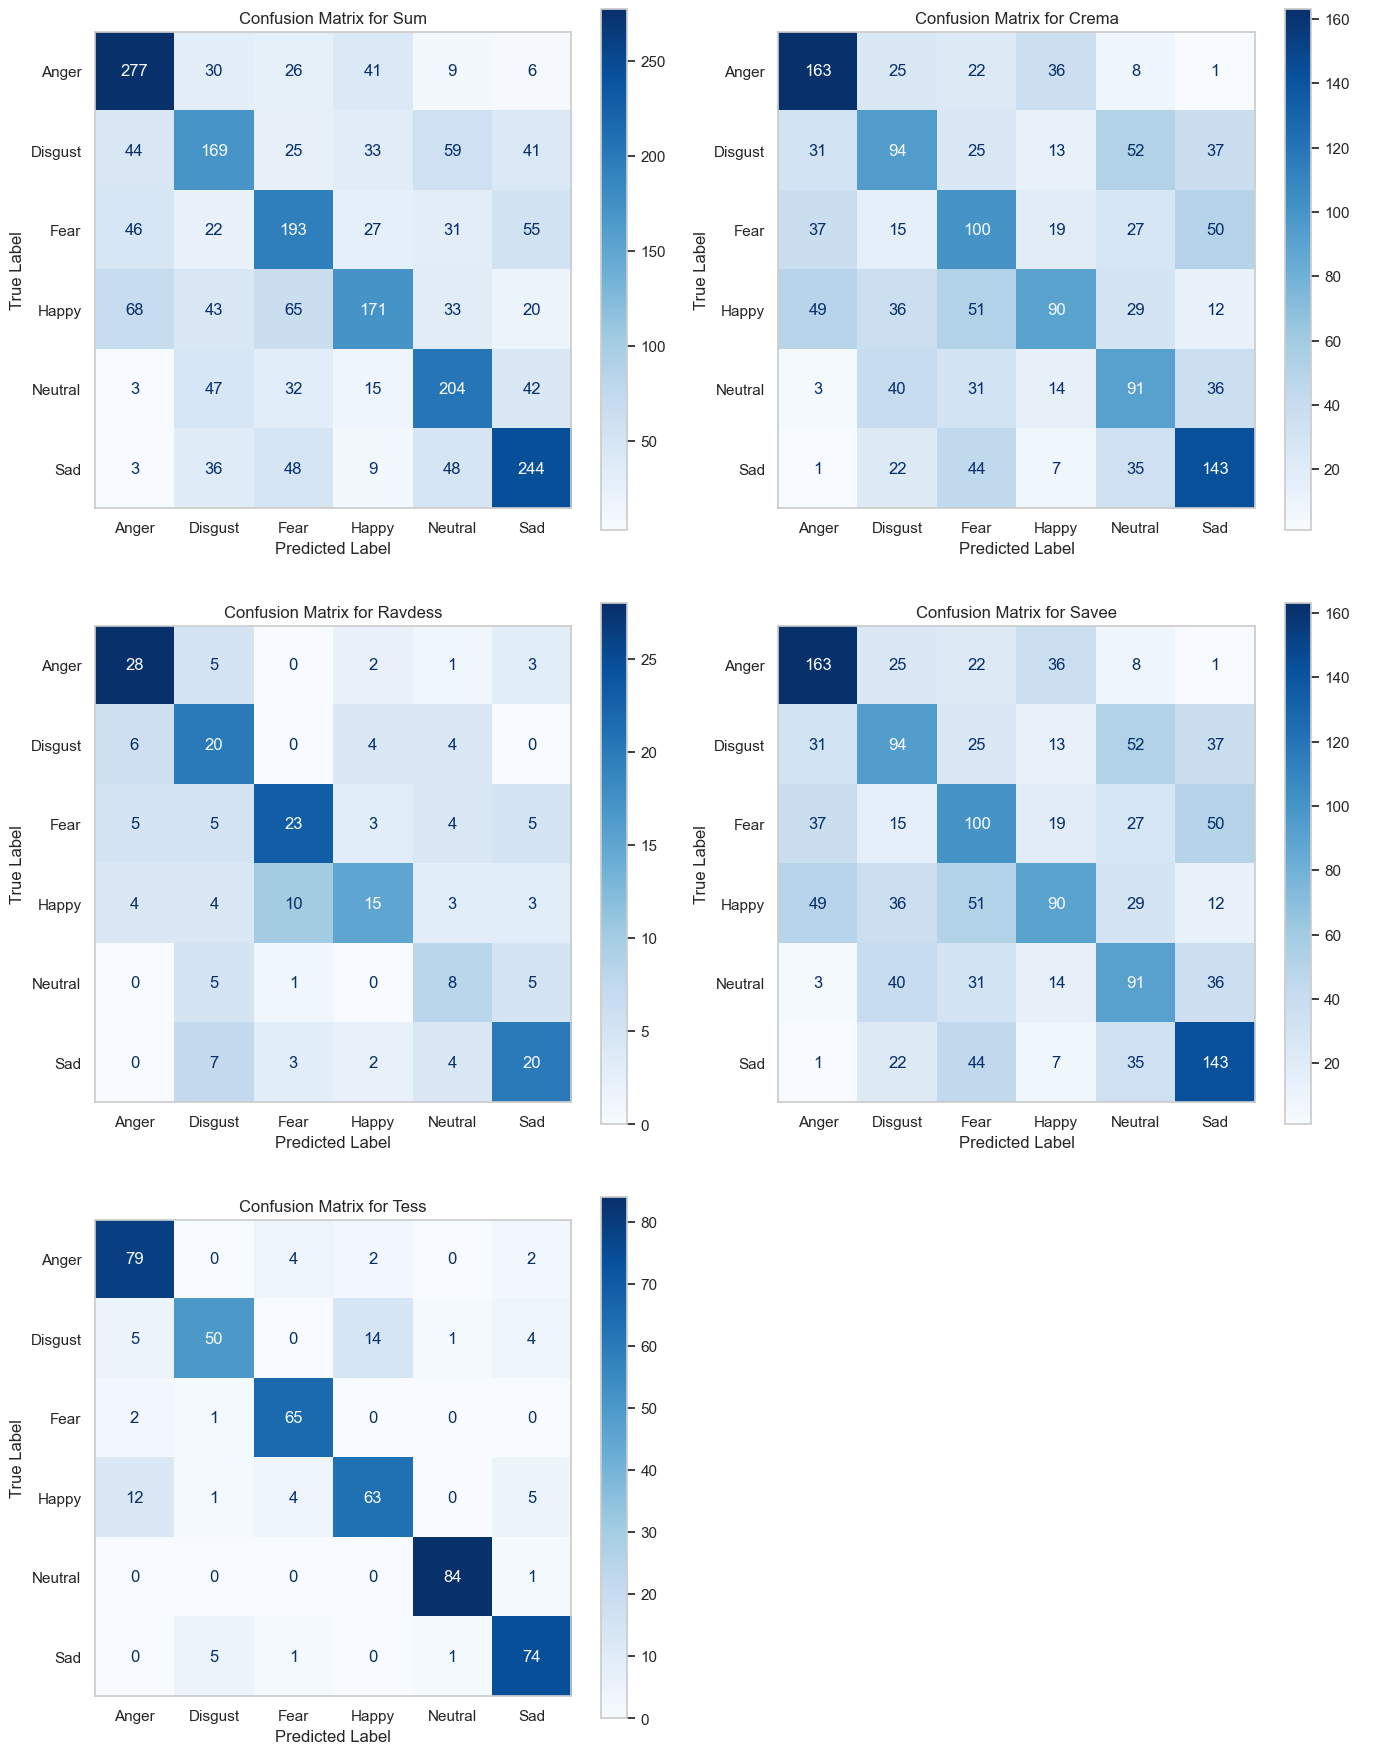

Accuracy for Sum: 55.54%
Accuracy for Crema: 45.74%
Accuracy for Ravdess: 53.77%
Accuracy for Savee: 45.74%
Accuracy for Tess: 86.46%


In [74]:
generate_confusion_matrix(model, test_data)